<table>
 <tr align=left><td><img align=left src="https://i.creativecommons.org/l/by/4.0/88x31.png">
 <td>Text provided under a Creative Commons Attribution license, CC-BY. All code is made available under the FSF-approved MIT license. (c) Kyle T. Mandli</td>
</table>

In [1]:
%matplotlib inline
#from __future__ import print_function
import numpy
import matplotlib.pyplot as plt

# Iterative Methods

In this lecture we will consider a number of classical and more modern methods for solving sparse linear systems like those we found from our consideration of boundary value problems.

## Ways to Solve $A u = f$

We have proposed solving the linear system $A u = f$ which we have implemented naively above with the `numpy.linalg.solve` command but perhaps given the special structure of $A$ here that we can do better.   

### Direct Methods (Gaussian Elimination)

We could use Gaussian elimination to solve the system (or some factorization) which leads to a solution in a finite number of steps.  For large, sparse methods however these direct solvers are much more expensive in general over iterative solvers.  As was discussed for eigenproblems, iterative solvers start with an initial guess and try to improve on that guess. 

#### Computational Load

Now consider using Gaussian elimination on the above matrix.  For good measure let us consider a 3D problem and discretize each dimension with a $N = 100$ leading to $m = 100 \times 100 \times 100 = 10^6$ unknowns.

Gaussian Elimination - $\mathcal{O}(m^3)$ operations to solve, $(10^6)^3 = 10^{18}$ operations.

Suppose you have a machine that can perform 100 gigaflops (floating point operations per second):
$$
    \frac{10^{18}~ [\text{flop}]}{10^{11}~ [\text{flop / s}]} = 10^7~\text{s} \approx 115~\text{days}.
$$

#### Memory Load

What about memory?

We require $m^2$ to store entire array.  In double precision floating point we would require 8-bytes per entry leading to
$$
    (10^6)^2 ~[\text{entries}] \times 8 ~[\text{bytes / entry}] = 8 \times 10^{12} ~[\text{bytes}] = 8 ~[\text{terabytes}].
$$

The situation really is not as bad as we are making it out to be as long as we take advantage of the sparse nature of the matrices.  In fact for 1 dimensional problems direct methods can be reduced to $\mathcal{O}(N)$ in the case for a tridiagonal system.  The situation is not so great for higher-dimensional problems however unless more structure can be leveraged.  Examples of these types of solvers include fast Fourier methods such as fast Poisson solvers.

### Iterative Methods

Iterative methods take a different tact than direct methods.  If we have the system $A x = b$ we form an iterative procedure that applies a function, say $L$, such that
$$
    \hat{x}^{(k)} = L(\hat{x}^{(k-1)})
$$
where we want errot between the real solution $x$ and $\hat{x}^{(k)}$ goes to zero as $k \rightarrow \infty$.  We will explore these methods in the next lecture.

## Jacobi and Gauss-Seidel

The Jacobi and Gauss-Seidel methods are simple approaches to introducing an iterative means for solving the problem $Ax = b$ when $A$ is sparse.  Consider again the Poisson problem $u_{xx} = f(x)$ and the finite difference approximation at the point $x_i$
$$
    \frac{U_{i-1} - 2 U_i + U_{i+1}}{\Delta x^2} = f(x_i).
$$

If we rearrange this expression to solve for $U_i$ we have
$$
    U_i = \frac{1}{2} (U_{i+1} + U_{i-1}) - f(x_i) \frac{\Delta x^2}{2}.
$$

For a direct method we would simultaneously find the values of $U_i$, $U_{i+1}$ and $U_{i-1}$ but instead consider the iterative scheme computes an update to the equation above by using the past iterate (values we already know)
$$
    U_i^{(k+1)} = \frac{1}{2} (U_{i+1}^{(k)} + U_{i-1}^{(k)}) - f(x_i) \frac{\Delta x^2}{2}.
$$

<font color = "red"> 
    We are smoothing this when averaging 

Since this allows us to evaluate $U_i^{(k + 1)}$ without knowing the values of $U_{i+1}^{(k)} + U_{i-1}^{(k)}$ we directly evaluate this expression!  This process is called **Jacobi iteration**.  It can be shown that for this particular problem Jacobi iteration will converge from any initial guess $U^{(0)}$ although slowly.

Advantages
 - Matrix $A$ is never stored or created
 - Storage is optimal
 - $\mathcal{O}(m)$ are required per iteration where $m$ is the number of unknowns

### Example
Let's try to solve the problem before in the BVP section but use Jacobi iterations to replace the direct solve
$$
    u_{xx} = e^x, \quad x \in [0, 1] \quad \text{with} \quad u(0) = 0.0, \text{ and } u(1) = 3.
$$

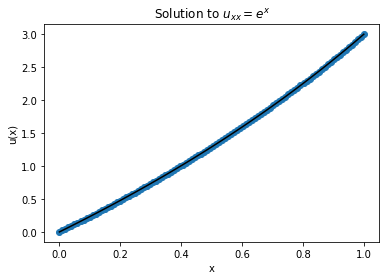

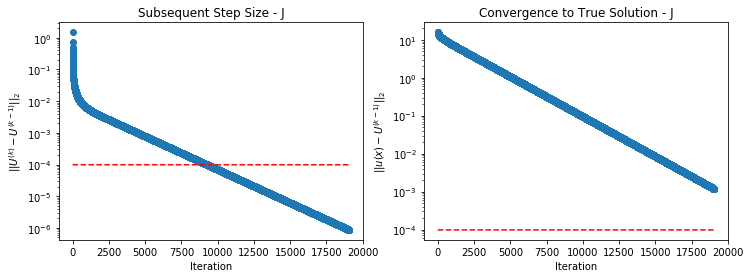

In [2]:
# Problem setup
a = 0.0
b = 1.0
u_a = 0.0
u_b = 3.0
f = lambda x: numpy.exp(x)
u_true = lambda x: (4.0 - numpy.exp(1.0)) * x - 1.0 + numpy.exp(x)

# Descretization
m = 100
x_bc = numpy.linspace(a, b, m + 2)
x = x_bc[1:-1]
delta_x = (b - a) / (m + 1)

# Expected iterations needed
iterations_J = int(2.0 * numpy.log(delta_x) / numpy.log(1.0 - 0.5 * numpy.pi**2 * delta_x**2))

# Solve system
# Initial guess for iterations
U_new = numpy.zeros(m + 2)
U_new[0] = u_a
U_new[-1] = u_b
convergence_J = numpy.zeros(iterations_J)
step_size_J = numpy.zeros(iterations_J)
for k in range(iterations_J):
    U = U_new.copy()
    for i in range(1, m + 1):
        U_new[i] = 0.5 * (U[i+1] + U[i-1]) - f(x_bc[i]) * delta_x**2 / 2.0

    step_size_J[k] = numpy.linalg.norm(U - U_new, ord=2)
    convergence_J[k] = numpy.linalg.norm(u_true(x_bc) - U_new, ord=2)
        
# Plot result
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.plot(x_bc, U, 'o', label="Computed")
axes.plot(x_bc, u_true(x_bc), 'k', label="True")
axes.set_title("Solution to $u_{xx} = e^x$")
axes.set_xlabel("x")
axes.set_ylabel("u(x)")

fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 2)
axes = fig.add_subplot(1, 2, 1)
axes.semilogy(list(range(iterations_J)), step_size_J, 'o')
axes.semilogy(list(range(iterations_J)), numpy.ones(iterations_J) * delta_x**2, 'r--')
axes.set_title("Subsequent Step Size - J")
axes.set_xlabel("Iteration")
axes.set_ylabel("$||U^{(k)} - U^{(k-1)}||_2$")
axes = fig.add_subplot(1, 2, 2)
axes.semilogy(list(range(iterations_J)), convergence_J, 'o')
axes.semilogy(list(range(iterations_J)), numpy.ones(iterations_J) * delta_x**2, 'r--')
axes.set_title("Convergence to True Solution - J")
axes.set_xlabel("Iteration")
axes.set_ylabel("$||u(x) - U^{(k-1)}||_2$")

plt.show()


<font color = "red"> 
    Red line is defined as a point where we think we converged enough. You need to change $\delta x$ to get a better solutuon. 

A slight modification to the above leads also to the Gauss-Seidel method.  Programmtically it is easy to see the modification but in the iteration above we now will have
$$
    U_i^{(k+1)} = \frac{1}{2} (U_{i+1}^{(k)} + U_{i-1}^{(k+1)}) - f(x_i) \frac{\Delta x^2}{2}.
$$

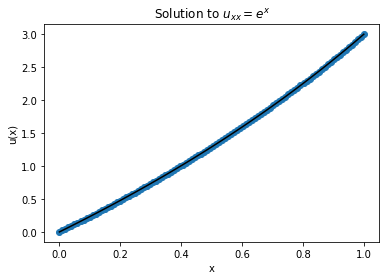

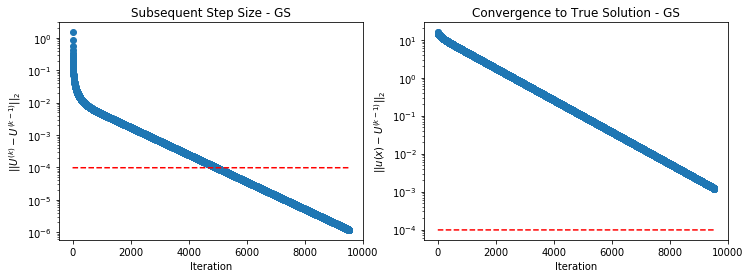

In [3]:
# Problem setup
a = 0.0
b = 1.0
u_a = 0.0
u_b = 3.0
f = lambda x: numpy.exp(x)
u_true = lambda x: (4.0 - numpy.exp(1.0)) * x - 1.0 + numpy.exp(x)

# Descretization
m = 100
x_bc = numpy.linspace(a, b, m + 2)
x = x_bc[1:-1]
delta_x = (b - a) / (m + 1)

# Expected iterations needed
iterations_GS = int(2.0 * numpy.log(delta_x) / numpy.log(1.0 - numpy.pi**2 * delta_x**2))

# Solve system
# Initial guess for iterations
U = numpy.zeros(m + 2)
U[0] = u_a
U[-1] = u_b
convergence_GS = numpy.zeros(iterations_GS)
step_size_GS = numpy.zeros(iterations_GS)
success = False
for k in range(iterations_GS):
    U_old = U.copy()
    for i in range(1, m + 1):
        U[i] = 0.5 * (U[i+1] + U[i-1]) - f(x_bc[i]) * delta_x**2 / 2.0

    convergence_GS[k] = numpy.linalg.norm(u_true(x_bc) - U, ord=2)
    step_size_GS[k] = numpy.linalg.norm(U_old - U, ord=2)

# Plot result
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.plot(x_bc, U, 'o', label="Computed")
axes.plot(x_bc, u_true(x_bc), 'k', label="True")
axes.set_title("Solution to $u_{xx} = e^x$")
axes.set_xlabel("x")
axes.set_ylabel("u(x)")

fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 2)
axes = fig.add_subplot(1, 2, 1)
axes.semilogy(list(range(iterations_GS)), step_size_GS, 'o')
axes.semilogy(list(range(iterations_GS)), numpy.ones(iterations_GS) * delta_x**2, 'r--')
axes.set_title("Subsequent Step Size - GS")
axes.set_xlabel("Iteration")
axes.set_ylabel("$||U^{(k)} - U^{(k-1)}||_2$")
axes = fig.add_subplot(1, 2, 2)
axes.semilogy(list(range(iterations_GS)), convergence_GS, 'o')
axes.semilogy(list(range(iterations_GS)), numpy.ones(iterations_GS) * delta_x**2, 'r--')
axes.set_title("Convergence to True Solution - GS")
axes.set_xlabel("Iteration")
axes.set_ylabel("$||u(x) - U^{(k-1)}||_2$")

plt.show()

### Matrix Splitting Methods

One way to view Jacobi and Gauss-Seidel is as a splitting of the matrix $A$ so that
$$
    A = M - N.
$$

Then the system $A U = b$ can be viewed as
$$
    M U - N U = b \Rightarrow MU = NU + b.
$$

Viewing this instead as an iteration we have then
$$
    M U^{(k+1)} = N U^{(k)} + b.
$$
The goal then would be to pick $M$ and $N$ such that $M$ contains as much of $A$ as possible while remaining easier to solve than the original system.

The resulting update for each of these then becomes
$$
    U^{(k+1)} = M^{-1} N U^{(k)} + M^{-1} b = G U^{(k)} + c
$$
where $G$ is called the **iteration matrix** and $c = M^{-1} b$.  We also want
$$
    u = G u + c
$$
where $u$ is the true solution of the original $A u = b$, in other words $u$ is the fixed point of the iteration.  Is this fixed point stable though?  If the spectral radius $\rho(G) < 1$ we can show that in fact the iteration is stable.

Note the similarity between our stability analysis dealing with $||A^{-1}||$ and now $G = M^{-1} N$ which is similar but not identical.

For Jacobi the splitting is 
$$
    M = -\frac{2}{\Delta x^2} I, \quad \text{and}\quad N = -\frac{1}{\Delta x^2} \begin{bmatrix}
        0 & 1 & \\
        1 & 0 & 1 \\
          & \ddots & \ddots & \ddots \\
          & & 1 & 0 & 1 \\
          & &   & 1 & 0
    \end{bmatrix}
$$
(sticking to the Poisson problem).  $M$ is now a diagonal matrix and easy to solve.

For Gauss-Seidel we have
$$
    M = \frac{1}{\Delta x^2} \begin{bmatrix}
        -2 &  & \\
         1 & -2 &  \\
           & \ddots & \ddots \\
           & & 1 & -2 & \\
           & &   & 1 & -2
    \end{bmatrix} \quad \text{and} \quad 
    N = -\frac{1}{\Delta x^2} \begin{bmatrix}
         0 & 1 & \\
          & 0 & 1 \\
          & & \ddots & \ddots \\
           & &  & 0 & 1\\
           & &   &  & 0
    \end{bmatrix}
$$

### Stopping Criteria

How many iterations should we perform?  Let $E^{(k)}$ represent the error present at step $k$.  If we want to reduce the error at the first step $E^{(0)}$ to order $\epsilon$ then we have
$$
    ||E^{(k)}|| \approx \epsilon ||E^{(0)}||.
$$

Under suitable assumption we can bound the error in the 2-norm as
$$
    ||E^{(k)}||_2 \leq \rho(G)^k ||E^{(0)}||_2.
$$
where $\rho(G)$ is the spectral radius of the iteration matrix.

Moving back to our estimate of the number of iterations we can combine our two expressions involving the error $E$ by taking $\Delta x \rightarrow 0$ which allows us to write
$$
    k \approx \frac{\log \epsilon}{\log \rho(G)}
$$
taking into account error convergence.  

Picking $\epsilon$ is a bit tricky but one natural criteria to use would be $\epsilon = \mathcal{O}(\Delta x^2)$ since our original discretization was 2nd-order accurate.  This leads to
$$
    k = \frac{2 \log \Delta x}{\log \rho}.
$$
This also allows us to estimate the total number of operations that need to be used.

For Jacobi we have the spectral radius of $G$ as
$$
    \rho_J \approx 1 - \frac{1}{2} \pi^2 \Delta x^2.
$$
so that
$$
    k = \mathcal{O}(m^2 \log m) \quad \text{as} \quad m \rightarrow \infty.
$$

Combining this with the previous operation count per iteration we find that **Jacobi would lead to $\mathcal{O}(m^3 \log m)$ work** which is not very promising.  

For two dimensions we have $\mathcal{O}(m^4 \log m)$ so even compared to Gaussian elimination this approach is not ideal.

What about Gauss-Seidel?  Here the spectral radius is approximately
$$
    \rho_{GS} \approx 1 - \pi^2 \Delta x^2
$$
so that
$$
    k = \frac{2 \times \log \Delta x}{\log (1 - \pi^2 \Delta x^2)}
$$
which still does not lead to any advantage over direct solvers.  It does show that Gauss-Seidel does actually converge faster due to the factor of 2 difference between $\rho_J$ and $\rho_{GS}$.

<font color = "red"> 
    GS is twice as fast as Jacobi due to the factor of 2 in the spectral radius

## Successive Overrelaxation (SOR)

Well that's a bit dissapointing isn't it?  These iterative schemes do not seem to be worth much but it turns out we can do better with a slight modification to Gauss-Seidel.  

If you look at Gauss-Seidel iteration it turns out it moves $U$ in the correct direction to $u$ but is very conservative in the amount.  If instead we do
$$\begin{aligned}
    U^{GS}_i &= \frac{1}{2} \left(U^{(k+1)}_{i-1} + U^{(k)}_{i+1} - \Delta x^2 f_i\right) \\
    U^{(k+1)}_i &= U_i^{(k)} + \omega \left( U_i^{GS} - U_i^{(k)}\right )
\end{aligned}$$
where we get to pick $\omega$ we can do much better.  

If $\omega = 1$ then we get back Gauss-Seidel.  

If $\omega < 1$ we move even less and converges even more slowly (although is sometimes used for multigrid under the name **underrelaxation**).  

If $\omega > 1$ then we move further than Gauss-Seidel suggests and any method where $\omega > 1$ is known as **successive overrelaxation** (SOR).

We can write this as a matrix splitting method as well.  We can combine the two-step formula above to find
$$
    U^{(k+1)}_i = \frac{\omega}{2} \left( U^{(k+1)}_{i-1} + U^{(k)}_{i+1} - \Delta x^2 f_i \right ) + (1 - \omega) U_i^{(k)}
$$
corresponding to a matrix splitting of
$$
    M = \frac{1}{\omega} (D - \omega L) \quad \text{and} \quad N = \frac{1}{\omega} ((1-\omega) D + \omega U)
$$
where $D$ is the diagonal of the matrix $A$, and $L$ and $U$ are the lower and upper triangular parts without the diagonal of $A$.

It can be shown that picking an $\omega$ such that $0 < \omega < 2$ the SOR method converges.  

It turns out we can also find an optimal $\omega$ for a wide class of problems.  For Poisson problems in any number of space dimensions for instance it can be shown that SOR method converges optimaly if
$$
    \omega_{opt} = \frac{2}{1 + \sin(\pi \Delta x)} \approx 2 - 2 \pi \Delta x.
$$

What about the number of iterations?  We can follow the same tactic as before with the spectral radius of $G_{SOR}$ now
$$
    \rho = \omega_{opt} - 1 \approx 1 - 2 \pi \Delta x.
$$

This leads to an iteration count of
$$
    k = \mathcal{O}(m \log m)
$$
an order of magnitude better than Gauss-Seidel alone!

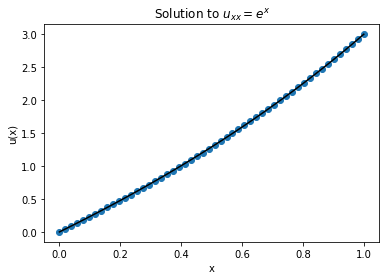

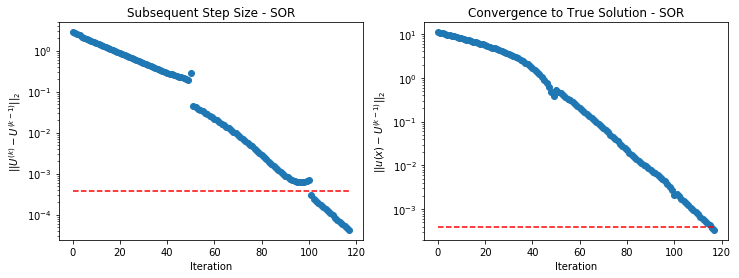

In [4]:
# Problem setup
a = 0.0
b = 1.0
u_a = 0.0
u_b = 3.0
f = lambda x: numpy.exp(x)
u_true = lambda x: (4.0 - numpy.exp(1.0)) * x - 1.0 + numpy.exp(x)

# Descretization
m = 50
x_bc = numpy.linspace(a, b, m + 2)
x = x_bc[1:-1]
delta_x = (b - a) / (m + 1)

# SOR parameter
omega = 2.0 / (1.0 + numpy.sin(numpy.pi * delta_x))

# Expected iterations needed
iterations_SOR = int(2.0 * numpy.log(delta_x) / numpy.log(1.0 - 2.0 * numpy.pi * delta_x)) * 2

# Solve system
# Initial guess for iterations
U = numpy.zeros(m + 2)
U[0] = u_a
U[-1] = u_b
step_size_SOR = numpy.zeros(iterations_SOR)
convergence_SOR = numpy.zeros(iterations_SOR)
for k in range(iterations_SOR):
    U_old = U.copy()
    for i in range(1, m + 1):
        U_gs = 0.5 * (U[i-1] + U[i+1] - delta_x**2 * f(x_bc[i]))
        U[i] += omega * (U_gs - U[i])

    step_size_SOR[k] = numpy.linalg.norm(U_old - U, ord=2)
    convergence_SOR[k] = numpy.linalg.norm(u_true(x_bc) - U, ord=2)
        
# Plot result
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.plot(x_bc, U, 'o', label="Computed")
axes.plot(x_bc, u_true(x_bc), 'k', label="True")
axes.set_title("Solution to $u_{xx} = e^x$")
axes.set_xlabel("x")
axes.set_ylabel("u(x)")

fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 2)
axes = fig.add_subplot(1, 2, 1)
axes.semilogy(list(range(iterations_SOR)), step_size_SOR, 'o')
axes.semilogy(list(range(iterations_SOR)), numpy.ones(iterations_SOR) * delta_x**2, 'r--')
axes.set_title("Subsequent Step Size - SOR")
axes.set_xlabel("Iteration")
axes.set_ylabel("$||U^{(k)} - U^{(k-1)}||_2$")
axes = fig.add_subplot(1, 2, 2)
axes.semilogy(list(range(iterations_SOR)), convergence_SOR, 'o')
axes.semilogy(list(range(iterations_SOR)), numpy.ones(iterations_SOR) * delta_x**2, 'r--')
axes.set_title("Convergence to True Solution - SOR")
axes.set_xlabel("Iteration")
axes.set_ylabel("$||u(x) - U^{(k-1)}||_2$")

plt.show()

<font color = "red"> 
    We see that SOR is much faster than G-S. The gaps are due to some sort of Graduent decent method (we can think of such) - error goes up a bit and then it drastically goes down. Iterations are much lower than G-S (order of magnitude). 

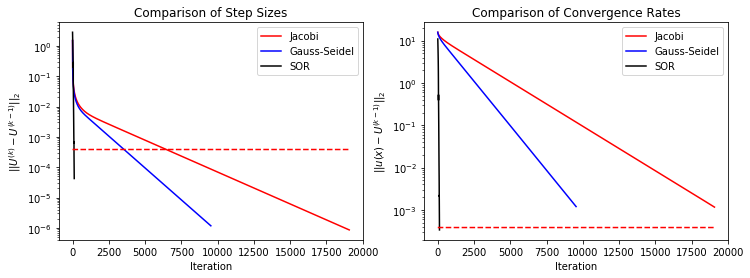

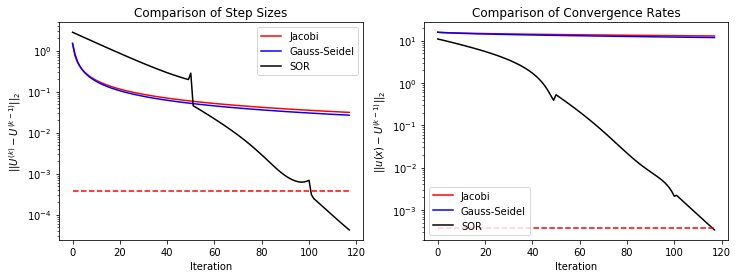

In [5]:
# Plotting all the convergence rates
fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 2)

axes = fig.add_subplot(1, 2, 1)
axes.semilogy(range(iterations_J), step_size_J, 'r', label="Jacobi")
axes.semilogy(range(iterations_GS),  step_size_GS, 'b', label="Gauss-Seidel")
axes.semilogy(range(iterations_SOR),  step_size_SOR, 'k', label="SOR")
axes.semilogy(range(iterations_J), numpy.ones(iterations_J) * delta_x**2, 'r--')
axes.legend(loc=1)
axes.set_title("Comparison of Step Sizes")
axes.set_xlabel("Iteration")
axes.set_ylabel("$||U^{(k)} - U^{(k-1)}||_2$")

axes = fig.add_subplot(1, 2, 2)
axes.semilogy(range(iterations_J), convergence_J, 'r', label="Jacobi")
axes.semilogy(range(iterations_GS),  convergence_GS, 'b', label="Gauss-Seidel")
axes.semilogy(range(iterations_SOR),  convergence_SOR, 'k', label="SOR")
axes.semilogy(range(iterations_J), numpy.ones(iterations_J) * delta_x**2, 'r--')
axes.legend(loc=1)
axes.set_title("Comparison of Convergence Rates")
axes.set_xlabel("Iteration")
axes.set_ylabel("$||u(x) - U^{(k-1)}||_2$")

fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 2)

axes = fig.add_subplot(1, 2, 1)
axes.semilogy(range(iterations_SOR), step_size_J[:iterations_SOR], 'r', label="Jacobi")
axes.semilogy(range(iterations_SOR),  step_size_GS[:iterations_SOR], 'b', label="Gauss-Seidel")
axes.semilogy(range(iterations_SOR),  step_size_SOR, 'k', label="SOR")
axes.semilogy(range(iterations_SOR), numpy.ones(iterations_SOR) * delta_x**2, 'r--')
axes.legend(loc=1)
axes.set_title("Comparison of Step Sizes")
axes.set_xlabel("Iteration")
axes.set_ylabel("$||U^{(k)} - U^{(k-1)}||_2$")

axes = fig.add_subplot(1, 2, 2)
axes.semilogy(range(iterations_SOR), convergence_J[:iterations_SOR], 'r', label="Jacobi")
axes.semilogy(range(iterations_SOR),  convergence_GS[:iterations_SOR], 'b', label="Gauss-Seidel")
axes.semilogy(range(iterations_SOR),  convergence_SOR, 'k', label="SOR")
axes.semilogy(range(iterations_SOR), numpy.ones(iterations_SOR) * delta_x**2, 'r--')
axes.legend(loc=3)
axes.set_title("Comparison of Convergence Rates")
axes.set_xlabel("Iteration")
axes.set_ylabel("$||u(x) - U^{(k-1)}||_2$")

plt.show()

## Descent Methods

One special case of matrices are amenable to another powerful way to iterate to the solution.  A matrix is said to be **symmetric positive definite** (SPD) if 
$$
    x^T A x > 0 \quad \forall \quad x \neq 0.
$$

Check to see if 
$$
    A = \begin{bmatrix}
        2 &-1 &0 &0 \\
        -1 & 2 & -1 & 0 \\
        0 & -1 & 2 & -1 \\
        0 & 0 & -1 & 2
    \end{bmatrix}
$$
is symmetric positive definite.

Now define a function $\phi: \mathbb R^m \rightarrow \mathbb R$ such that
$$
    \phi(u) = \frac{1}{2} u^T A u - u^T f.
$$
This is a quadratic function in the variables $u_i$ and in the case where $m = 2$ forms a parabolic bowl.  Since this is a quadratic function there is a unique minimum, $u^\ast$.  

Lets see how approaching the problem like this helps us:

For the $m = 2$ case write the function $\phi(u)$ out.

$$
    \phi(u) = \frac{1}{2} (A_{11} u_1^2 + A_{12} u_1 u_2 + A_{21} u_1 u_2 + A_{22} u^2_2) - u_1 f_1 - u_2 f_2
$$

What property of the matrix $A$ simplifies the expression above?

   Symmetry!  This implies that $A_{21} = A_{12}$ and the expression above simplifies to 
   $$
       \phi(u) = \frac{1}{2} (A_{11} u_1^2 + 2 A_{12} u_1 u_2 + A_{22} u^2_2) - u_1 f_1 - u_2 f_2
   $$

Now write two expressions that when evaluated at $u^\ast$ are identically 0 that express that $u^\ast$ minimizes $\phi(u)$.

   

Since $u^\ast$ minimizes $\phi(u)$ we know that the first derivatives should be zero at the minimum:
   $$\begin{aligned}
       \frac{\partial \phi}{\partial u_1} &= A_{11} u_1 + A_{12} u_2 - f_1 = 0 \\
       \frac{\partial \phi}{\partial u_1} &= A_{21} u_1 + A_{22} u_2 - f_2 = 0
   \end{aligned}$$
   Note that these equations can be rewritten as
   $$
       A u = f.
   $$

Therefore $\min \phi$ is equivalent to solving $A u = f$!

This is a common type of reformulation for many problems where it may be easier to treat a given equation as a minimization problem rather than directly solve it.

<font color = "red"> 
    Related to minimizing energy in physics.

Note that this is not quite the matrix that we have been using for our Poisson problem so far which is actually symmetric negative definite although these same methods work as well.  In this case we actually want to find the maximum of $\phi$ instead, other than that everything is the same.

Also note that if $A$ is indefinite then the eigenvalues of $A$ will change sign and instead of a stable minimum or maximum we have a saddle point which are much more difficult to handle (GMRES can for instance).

<font color = "red"> 
    GMRES? - Residual type of idea. Related to stochastic gradient decent. Add some randomness to the decent idea to get the min faster.

### Method of Steepest Descent

So now we turn to finding the $u^\ast$ that minimizes the function $\phi(u)$.  The simplest approach to this is called the **method of steepest descent** which finds the direction of the largest gradient of $\phi(u)$ and goes in that direction.  

Mathematically we then have
$$
    u^{(k+1)} = u^{(k)} - \alpha^{(k)} \nabla \phi(u^{(k)})
$$
where $\alpha^{(k)}$ will be the step size chosen in the direction we want to go.  

We can find $\alpha$ by
$$
    \alpha^{(k)} = \min_{\alpha \in \mathbb R} \phi\left(u^{(k)} - \alpha \nabla \phi(u^{(k)}\right),
$$
i.e. the $\alpha$ that takes us just far enough so that if we went any further $\phi$ would increase.  

This implies that $\alpha^{(k)} \geq 0$ and $\alpha^{(k)} = 0$ only if we are at the minimum of $\phi$.  We can compute the gradient of $\phi$ as
$$
    \nabla \phi(u^{(k)}) = A u^{(k)} - f \equiv -r^{(k)}
$$
where $r^{(k)}$ is the residual defined as
$$
    r^{(k)} = f - A u^{(k)}.
$$

Looking back at the definition of $\alpha^{(k)}$ then leads to the conclusion that the $\alpha$ that would minimize the expression would be the one that satisfies
$$
    \frac{\text{d} \phi(\alpha)}{\text{d} \alpha} = 0. 
$$

To find this note that
$$
    \phi(u + \alpha r) = \left(\frac{1}{2} u^T A u - u^T f \right) + \alpha(r^T A u - r^T f) + \frac{1}{2} \alpha^2 r^T A r
$$
so that the derivative becomes
$$
    \frac{\text{d} \phi(\alpha)}{\text{d} \alpha} = r^T A u - r^T f + \alpha r^T A r
$$

Setting this to zero than leads to
$$
    \alpha = \frac{r^T r}{r^T A r}.
$$

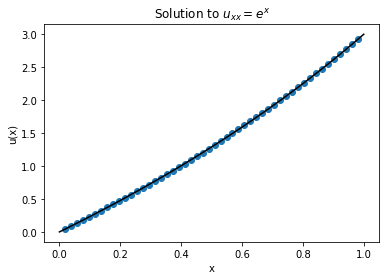

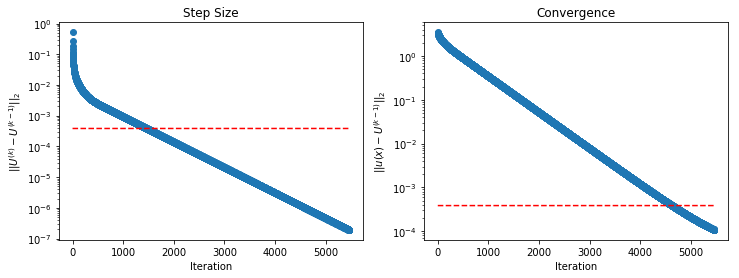

In [6]:
# Problem setup
a = 0.0
b = 1.0
u_a = 0.0
u_b = 3.0
f = lambda x: numpy.exp(x)
u_true = lambda x: (4.0 - numpy.exp(1.0)) * x - 1.0 + numpy.exp(x)

# Descretization
m = 50
x_bc = numpy.linspace(a, b, m + 2)
x = x_bc[1:-1]
delta_x = (b - a) / (m + 1)

# Construct matrix A
A = numpy.zeros((m, m))
diagonal = numpy.ones(m) / delta_x**2
A += numpy.diag(diagonal * 2.0, 0)
A += numpy.diag(-diagonal[:-1], 1)
A += numpy.diag(-diagonal[:-1], -1)

# Construct right hand side
b = -f(x)
b[0] += u_a / delta_x**2
b[-1] += u_b / delta_x**2

# Algorithm parameters
MAX_ITERATIONS = 10000
tolerance = 1e-3

# Solve system
U = numpy.empty(m)
convergence_SD = numpy.zeros(MAX_ITERATIONS)
step_size_SD = numpy.zeros(MAX_ITERATIONS)
success = False
for k in range(MAX_ITERATIONS):
    r = b - numpy.dot(A, U)
    if numpy.linalg.norm(r, ord=2) < tolerance:
        success = True
        break
        
    alpha = numpy.dot(r, r) / numpy.dot(r, numpy.dot(A, r))
    U = U + alpha * r

    step_size_SD[k] = numpy.linalg.norm(alpha * r, ord=2)
    convergence_SD[k] = numpy.linalg.norm(u_true(x) - U, ord=2)
        
if not success:
    print("Iteration failed to converge!")
    print(convergence_SD[-1])
else:
    # Plot result
    fig = plt.figure()
    axes = fig.add_subplot(1, 1, 1)
    axes.plot(x, U, 'o', label="Computed")
    axes.plot(x_bc, u_true(x_bc), 'k', label="True")
    axes.set_title("Solution to $u_{xx} = e^x$")
    axes.set_xlabel("x")
    axes.set_ylabel("u(x)")

    fig = plt.figure()
    fig.set_figwidth(fig.get_figwidth() * 2)
    
    axes = fig.add_subplot(1, 2, 1)
    axes.semilogy(list(range(k)), step_size_SD[:k], 'o')
    axes.semilogy(list(range(k)), numpy.ones(k) * delta_x**2, 'r--')
    axes.set_title("Step Size")
    axes.set_xlabel("Iteration")
    axes.set_ylabel("$||U^{(k)} - U^{(k-1)}||_2$")

    axes = fig.add_subplot(1, 2, 2)
    axes.semilogy(list(range(k)), convergence_SD[:k], 'o')
    axes.semilogy(list(range(k)), numpy.ones(k) * delta_x**2, 'r--')
    axes.set_title("Convergence")
    axes.set_xlabel("Iteration")
    axes.set_ylabel("$||u(x) - U^{(k-1)}||_2$")
    plt.show()

#### Convergence of Steepest Descent

What controls the convergence of steepest descent?  It turns out that the shape of the parabolic bowl formed by $\phi$ is the major factor determining the convergence of steepest descent.  

For example, if $A$ is a scalar multiple of the identity than these ellipses are actually circles and steepest descent converges in $m$ steps.  If $A$ does not lead to circles, the convergence is based on the ratio between the semi-major and semi-minor axis of the resulting ellipses $m$ dimensional ellipses.  

This is controlled by the smallest and largest eigenvalues of the matrix $A$ hence why steepest descent grows increasingly difficult as $m$ increases for the Poisson problem.  Note that this also relates to the condition number of the matrix in the $\ell_2$ norm.

![Ellipses](./images/ellipses.png)

Iteration count: 1
Iteration count: 8
Iteration count: 83


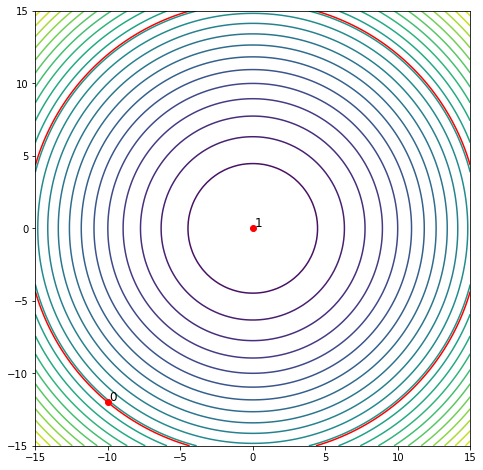

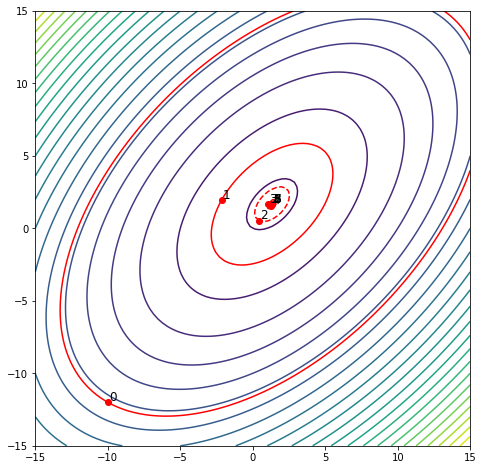

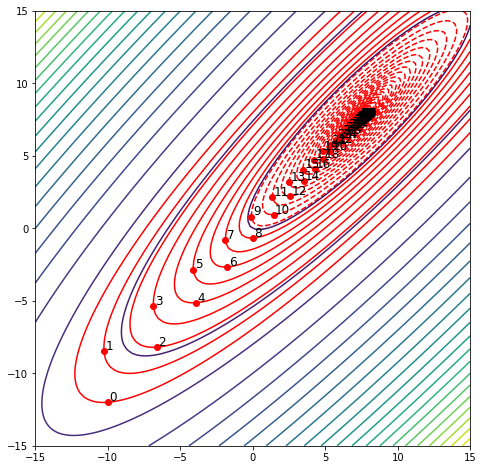

In [7]:
def steepest_descent(A, U, b, axes):
    MAX_ITERATIONS = 10000
    tolerance = 1e-3
    success = False
    iteration_locations = []
    for k in range(MAX_ITERATIONS):
        axes.text(U[0] + 0.1, U[1] + 0.1, str(k), fontsize=12)
        axes.plot(U[0], U[1], 'ro')
        iteration_locations.append(U)
        r = b - numpy.dot(A, U)
        if numpy.linalg.norm(r, ord=2) < tolerance:
            success = True
            break

        alpha = numpy.dot(r, r) / numpy.dot(r, numpy.dot(A, r))
        U = U + alpha * r
        
    if success:
        return k, iteration_locations
    else:
        raise Exception("Iteration did not converge.")

phi = lambda X, Y, A: 0.5 * (A[0, 0] * X**2 + A[0, 1] * X * Y + A[1, 0] * X * Y + A[1, 1] * Y**2) - X * f[0] - Y * f[1]

x = numpy.linspace(-15, 15, 100)
y = numpy.linspace(-15, 15, 100)
X, Y = numpy.meshgrid(x, y)

fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 2)
fig.set_figheight(fig.get_figheight() * 2)
axes = fig.add_subplot(1, 1, 1, aspect='equal')
A = numpy.identity(2)
f = numpy.array([0.0, 0.0])
k, iteration_locations = steepest_descent(A, numpy.array([-10.0, -12.0]), f, axes)
phi_levels = numpy.array([phi(U[0], U[1], A) for U in iteration_locations])
phi_levels.sort()
axes.contour(X, Y, phi(X, Y, A), levels=phi_levels, colors='r')
axes.contour(X, Y, phi(X, Y, A), 25)
print("Iteration count: %s" % k)

fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 2)
fig.set_figheight(fig.get_figheight() * 2)
axes = fig.add_subplot(1, 1, 1, aspect='equal')
A = numpy.array([[2, -1], [-1, 2]])
f = numpy.array([1.0, 2.0])
k, iteration_locations = steepest_descent(A, numpy.array([-10.0, -12.0]), f, axes)
phi_levels = numpy.array([phi(U[0], U[1], A) for U in iteration_locations])
phi_levels.sort()
axes.contour(X, Y, phi(X, Y, A), levels=phi_levels, colors='r')
axes.contour(X, Y, phi(X, Y, A), 25)
print("Iteration count: %s" % k)

fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 2)
fig.set_figheight(fig.get_figheight() * 2)
axes = fig.add_subplot(1, 1, 1, aspect='equal')
A = numpy.array([[2, -1.8], [-1.8, 2]])
f = numpy.array([1.0, 2.0])
k, iteration_locations = steepest_descent(A, numpy.array([-10.0, -12.0]), f, axes)
phi_levels = numpy.array([phi(U[0], U[1], A) for U in iteration_locations])
phi_levels.sort()
axes.contour(X, Y, phi(X, Y, A), levels=phi_levels, colors='r')
axes.contour(X, Y, phi(X, Y, A), 25)
print("Iteration count: %s" % k)

Each of these ellipses is related to the eigenstructure of $A$ such that
$$
    A v_j - f = \lambda_j (v_j - u^\ast)
$$
for some $\lambda_j$.  Knowing that $A u^\ast = f$ leads to
$$
    A (v_j - u^\ast) = \lambda_j (v_j - u^\ast)
$$
therefore $v_j - u^\ast$ form the eigenvectors of the matrix $A$ with corresponding eigenvalues $\lambda_j$.

If a particular set of $\lambda_j$s are not distinct than the ellipse is in fact a circle, demonstrating that any direction pointing to $u^\ast$ in this direction is an eigenvector (non-unique in this sub-space).

We can also relate this eigenstructure and geometric arguments to the matrix's condition number $\kappa$.  Let $v_1$ and $v_2$ be vectors that lie along the curve $\phi(u) = 1$, we then have
$$
    \frac{1}{2} v^T_j A v_j - v_j^T A u^\ast = 1.
$$
Combining this expression with our previous eigenvector expression and taking the inner-product with the eigenvector $v_j - u^\ast$ leads to
$$
    ||v_j - u^\ast||^2_2 = \frac{2 + (u^\ast)^T A u^\ast}{\lambda_j}.
$$
Now turning back to $v_1$ and $v_2$ we have their ratios as
$$
    \frac{||v_1 - u^\ast||_2}{||v_2 - u^\ast||_2} = \sqrt{\frac{\lambda_2}{\lambda_1}} = \sqrt{\kappa_2(A)}.
$$
This last expression tells us that the more ellipsoidal these sub-spaces are the more difficult it will be to solve $A u^\ast = f$.

### Projection Interpretation

One way to interpret the method of steepest descent is as an iterative projection method.  

Say we want to solve $A x = b$, $A \in \mathbb R^{m \times m}$ and $b \in \mathbb R^m$.  

Let us suppose we have two subspaces in $\mathbb R^m$, $\mathcal K$ the search subspace, and $\mathcal L$ the subspace of constraints.  The condition
$$
    b - A x \perp \mathcal{L}
$$
suggests that the residual vector $b - A x$ is orthogonal to the $\mathcal{L}$ subspace.

But how does $\mathcal K$ fit into this?  Modify the original statement so that
$$
    \tilde{x~} \in \mathcal{K}
$$
and then
$$
    b - A \tilde{x~} \perp \mathcal{L}.
$$
These are known as *Petrov-Galerkin* conditions.

If $\mathcal{K} = \mathcal{L}$ then this is an orthogonal projection.

Turning this into an iterative method let our initial guess be $x^{(0)}$, then
$$
    \tilde{x~} \in x^{(0)} + \mathcal{K}
$$
such that
$$
    b - A \tilde{x~} \perp \mathcal{L}.
$$
Note that this implies that we are expanding the search space by the part of $\text{span}(x^{(0)})$ that is not included in $\mathcal{K}$.

We can rewrite this in a more suggestive form by letting
$$
    \tilde{x~} = x^{(0)} + \delta
$$
where $\delta \in \mathcal{K}$ is some vector that will be our step.  Also assign the residual vector an index so that we have
$$
    r^{(k)} = b - A x^{(k)}
$$
at the $k$th step.

We then formulate a new problem such that
$$
    r^{(0)} - A \delta \perp \mathcal{L}
$$
leading to an iteration like statement:
$$\begin{aligned}
    \tilde{x~} &= x^{(0)} + \delta, & \quad \quad & \delta \in \mathcal{K} \\
    (r^{(0)} - A \delta) \cdot w &= 0 & \quad \quad & \forall w \in \mathcal{L}
\end{aligned}$$

#### Example:  One-Dimensional Projection

One-dimensional projection methods simply construct $\mathcal{K}$ and $\mathcal{L}$ such that they are
$$
    \mathcal{K} = \text{span}(v) \quad\quad \mathcal{L} = \text{span}(w)
$$
for two vectors $v$ and $w$.  In this case we can write the projection update as
$$
    x^{(k+1)} = x^{(k)} + \alpha r
$$
where $r$ is the residual and 
$$
    \alpha = \frac{r \cdot w}{A v \cdot w}.
$$

In the case of steepest descent $v = w = r$ noting that these lead to orthogonal projections as $\mathcal{K} = \mathcal{L}$.

Generalizing this a bit we can think of the steepest descent method in terms of projections.  Let $\mathcal{K} = \mathcal{L}$ and again assume that $A$ is symmetric positive-definite.  Define the error at the $k$th step as
$$
    E^{(k)} = x^\ast - x^{(k)}.
$$

In this case consider a single step from $k=0$ to $k=1$.  Then we would have
$$
    r^{(1)} = b - A (x^{(0)} + \delta) = r^{(0)} - A \delta
$$
and
$$
    A E^{(1)} = r^{(1)} = A(E^{(0)} - \delta)
$$
where $\delta$ is a result of the projection so that
$$ 
    (r^{(0)} - A \delta) \cdot w = 0 \quad \quad \forall w \in \mathcal{K}.
$$

### $A$-Conjugate Search Directions and Conjugate Gradient

An alternative to steepest descent is to choose a slightly different direction to descend down.  Generalizing our step from above let the iterative scheme be  
$$
    u^{(k+1)} = u^{(k)} - \alpha^{(k)} p^{(k)}
$$
and as before we want to pick an $\alpha$ such that
$$
    \min_{\alpha} \phi(u^{(k)} - \alpha p^{(k)})
$$
leading again to the choice of $\alpha$ of
$$
    \alpha^{(k)} = \frac{(p^{(k)})^T p^{(k)}}{(p^{(k)})^T A p^{(k)}}
$$
accept now we are also allowed to pick the search direction $p^{(k)}$.  

Ways to choose $p^{(k)}$:
 - One bad choice for $p$ would be orthogonal to $r$ since this would then be tangent to the level set (ellipse) of $\phi(u^{(k)})$ and would cause it to only increase so we want to make sure that $p^T r \neq 0$ (the inner-product).
 - We also want to still move downwards so require that $\phi(u^{(k+1)}) < \phi(u^{(k)})$.

We know that $r^{(k)}$ is not always the best direction to go in but what might be better?  

We could head directly for the minimum but how do we do that without first knowing $u^\ast$?  

It turns out when $m=2$ we can do this an from any initial guess $u^{(0)}$ and initial direction $p^{(0)}$ we will arrive at the minimum in 2 steps if we choose the second search direction dependent on
$$
    (p^{(1)})^T A p^{(0)} = 0.
$$
In general if two vectors satisfy this property they are said to be $A$-conjugate.

Note that if $A = I$ then these two vectors would be orthogonal to each other and in this sense $A$-conjugacy is a natural extension from orthogonality and the simple case from before where the ellipses are circles to the case where we can have very distorted ellipses.  

In fact the vector $p^{(0)}$ is tangent to the level set that $u^{(1)}$ lies on and therefore choosing $p^{(1)}$ so that it is $A$-conjugate to $p^{(0)}$ then always heads to the center of the ellipse. 

To show this, take the initial direction $p^{(0)}$ and note that it is tangent to the level set of $\phi$ at $u_1$ so $p^{(0)}$ is orthogonal to the residual.  Looking at the residual of one step we have
$$
    r_1 = f - A u_1 = Au^\ast - A u_1 = A(u^\ast - u_1) \Rightarrow (p^{(0)})^T A (u^\ast - u_1) = 0.
$$

Knowing then that $u^\ast - u_1 = \alpha p_1$ we can then conclude
$$
    p_0^T A p_1 = 0
$$
given that $\alpha \neq 0$.

The fact that the initial guess minimizes the residual in its direction is an important idea we will see again.

In other words, once we know a tangent to one of the ellipses we can always choose a direction that minimizes in one of the dimensions of the search space.  Choosing the $p^{(k)}$ iteratively this way forms the basis of the **conjugate gradient** method.

![Ellipses CG](./images/ellipses_CG.png)

Now to generalize beyond $m = 2$ consider the $m=3$ case.  As stated before we are now in a three-dimensional space where the level-sets are concentric ellipsoids.  Taking a slice through this space will lead to an ellipse on the slice.

1. Start with an initial guess $u^{(0)}$ and choose a search direction $p^{(0)}$.
1. Minimize $\phi(u)$ in the direction $u^{(0)} + \alpha p^{(0)}$ resulting in the choice
$$
    \alpha^{(0)} = \frac{(p^{(0)})^T p^{(0)}}{(p^{(0)})^T A p^{(0)}}
$$
as we saw before.  Now set $u^{(1)} = u^{(0)} + \alpha^{(0)} p^{(0)}$.
1. Choose $p^{(1)}$ to be $A$-conjugate to $p^{(0)}$.  In this case there are an infinite set of vectors that are possible that satisfy $(p^{(1)})^T A p^{(0)} = 0$.  Beyond requiring $p^{(1)}$ to be $A$-conjugate we also want it to be linearly-independent to $p^{(0)}$.
1. Again choose an $\alpha^{(1)}$ that minimizes the residual (again tangent to the level sets of $\phi$) in the direction $p^{(1)}$ and repeat the process

So why does this work so much better than steepest descent?

Since we have chosen $p^{(0)}$ and $p^{(1)}$ to be linearly independent they span a two-dimensional subspace in $\mathbb R^m$.  We then choose to travel through this subspace as to minimize the residual in this space.  Geometrically we have cut out space with this plane leading to a two-dimensional subspace with concentric ellipses representing the level sets of $\phi$.  We then choose an $\alpha$ so that we arrive at the center of these ellipses.

Matrix condition number = 68.81258394163932


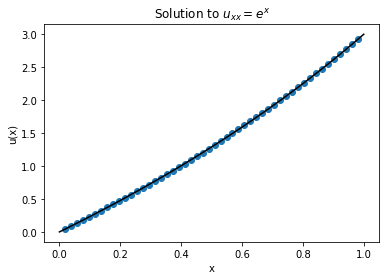

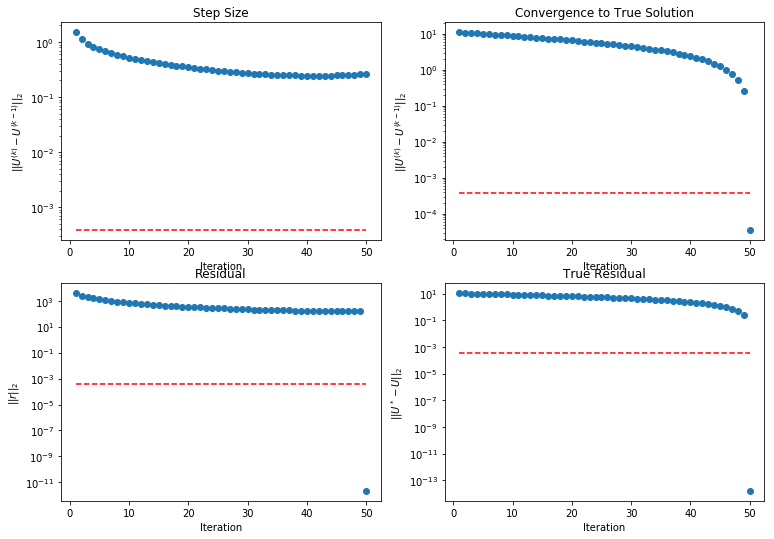

In [8]:
# Problem setup
a = 0.0
b = 1.0
alpha = 0.0
beta = 3.0
f = lambda x: numpy.exp(x)
u_true = lambda x: (4.0 - numpy.exp(1.0)) * x - 1.0 + numpy.exp(x)

# Descretization
m = 50
x_bc = numpy.linspace(a, b, m + 2)
x = x_bc[1:-1]
delta_x = (b - a) / (m + 1)

# Construct matrix A
A = numpy.zeros((m, m))
diagonal = numpy.ones(m) / delta_x**2
A += numpy.diag(diagonal * 2.0, 0)
A += numpy.diag(-diagonal[:-1], 1)
A += numpy.diag(-diagonal[:-1], -1)

# Construct right hand side
b = -f(x)
b[0] += alpha / delta_x**2
b[-1] += beta / delta_x**2

# Exact solution to system
U_true = numpy.linalg.solve(A, b)

# Algorithm parameters
MAX_ITERATIONS = 10000
tolerance = delta_x**2

# Solve system
U = numpy.zeros(m)
convergence_CG = numpy.zeros(MAX_ITERATIONS)
step_size_CG = numpy.zeros(MAX_ITERATIONS)
residual_norm = numpy.zeros(MAX_ITERATIONS)
system_convergence = numpy.zeros(MAX_ITERATIONS)
success = False
r = -(b - numpy.dot(A, U))
p = -r
r_dot_r = numpy.dot(r, r)
for k in range(MAX_ITERATIONS):
    # Convergence measures (not needed)
    U_old = U.copy()
    r_old = r.copy()
    
    if numpy.linalg.norm(r, ord=2) < tolerance:
        success = True
        break
    
    A_dot_p = numpy.dot(A, p)
    
    # Step length
    alpha =  r_dot_r / numpy.dot(p, A_dot_p)
    
    # Update solution and residual
    U += alpha * p
    r += alpha * A_dot_p

    # Improvement of solution
    beta = numpy.dot(r, r) / r_dot_r
    r_dot_r = numpy.dot(r, r)
    
    # Pick new direction for next iteration (if needed)
    p = beta * p - r

    # Convergence measures
    convergence_CG[k] = numpy.linalg.norm(u_true(x) - U, ord=2)
    residual_norm[k] = numpy.linalg.norm(r, ord=2)
    step_size_CG[k] = numpy.linalg.norm(U - U_old, ord=2)
    system_convergence[k] = numpy.linalg.norm(U_true - U, ord=2)

if not success:
    print("Iteration failed to converge!")
    print(residual_norm[-10:])
    print(convergence_CG[-10:])
else:
    # Plot result
    fig = plt.figure()
    axes = fig.add_subplot(1, 1, 1)
    axes.plot(x, U, 'o', label="Computed")
    axes.plot(x_bc, u_true(x_bc), 'k', label="True")
    axes.set_title("Solution to $u_{xx} = e^x$")
    axes.set_xlabel("x")
    axes.set_ylabel("u(x)")

    fig = plt.figure()
    fig.set_figwidth(fig.get_figwidth() * 2.1)
    fig.set_figheight(fig.get_figheight() * 2.2)
    
    axes = fig.add_subplot(2, 2, 1)
    axes.semilogy(numpy.arange(1, k + 1), step_size_CG[:k], 'o')
    axes.semilogy(numpy.arange(1, k + 1), numpy.ones(k) * delta_x**2, 'r--')
    axes.set_title("Step Size")
    axes.set_xlabel("Iteration")
    axes.set_ylabel("$||U^{(k)} - U^{(k-1)}||_2$")
    
    axes = fig.add_subplot(2, 2, 2)
    axes.semilogy(numpy.arange(1, k + 1), convergence_CG[:k], 'o')
    axes.semilogy(numpy.arange(1, k + 1), numpy.ones(k) * delta_x**2, 'r--')
    axes.set_title("Convergence to True Solution")
    axes.set_xlabel("Iteration")
    axes.set_ylabel("$||U^{(k)} - U^{(k-1)}||_2$")

    axes = fig.add_subplot(2, 2, 3)
    axes.semilogy(numpy.arange(1, k + 1), residual_norm[:k], 'o')
    axes.semilogy(numpy.arange(1, k + 1), numpy.ones(k) * delta_x**2, 'r--')
    axes.set_title("Residual")
    axes.set_xlabel("Iteration")
    axes.set_ylabel("$||r||_2$")

    axes = fig.add_subplot(2, 2, 4)
    axes.semilogy(numpy.arange(1, k + 1), system_convergence[:k], 'o')
    axes.semilogy(numpy.arange(1, k + 1), numpy.ones(k) * delta_x**2, 'r--')
    axes.set_title("True Residual")
    axes.set_xlabel("Iteration")
    axes.set_ylabel("$||U^* - U||_2$")
    
    print("Matrix condition number = %s" % (numpy.sqrt(numpy.linalg.norm(A) * numpy.linalg.norm(numpy.linalg.inv(A)))))
    
    plt.show()

Iteration count: 1
Iteration count: 2
Iteration count: 2


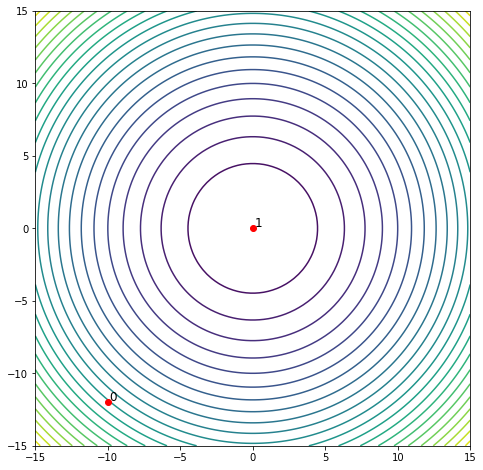

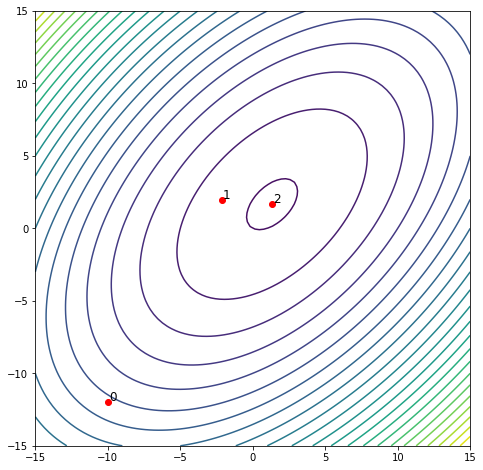

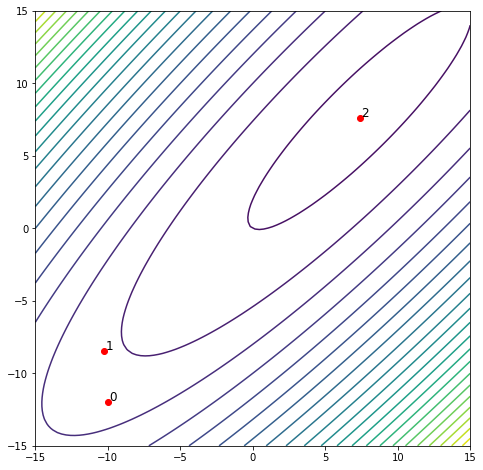

In [9]:
def CG(A, U, b, axes):
    MAX_ITERATIONS = A.shape[0] * 2
    tolerance = 1e-8
    success = False
    iteration_locations = []
    
    r = -(b - numpy.dot(A, U))
    p = -r
    r_dot_r = numpy.dot(r, r)
    for k in range(MAX_ITERATIONS):
        axes.text(U[0] + 0.1, U[1] + 0.1, str(k), fontsize=12)
        axes.plot(U[0], U[1], 'ro')
        iteration_locations.append(U)
        if numpy.linalg.norm(r, ord=2) < tolerance:
            success = True
            break

        A_dot_p = numpy.dot(A, p)

        # Step length
        alpha =  r_dot_r / numpy.dot(p, A_dot_p)

        # Update solution and residual
        U += alpha * p
        r += alpha * A_dot_p

        # Improvement of solution
        beta = numpy.dot(r, r) / r_dot_r
        r_dot_r = numpy.dot(r, r)

        # Pick new direction for next iteration (if needed)
        p = beta * p - r
    
    if success:
        return k, iteration_locations
    else:
        raise Exception("Iteration did not converge.")

phi = lambda X, Y, A: 0.5 * (A[0, 0] * X**2 + A[0, 1] * X * Y + A[1, 0] * X * Y + A[1, 1] * Y**2) - X * f[0] - Y * f[1]

x = numpy.linspace(-15, 15, 100)
y = numpy.linspace(-15, 15, 100)
X, Y = numpy.meshgrid(x, y)

fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 2)
fig.set_figheight(fig.get_figheight() * 2)
axes = fig.add_subplot(1, 1, 1, aspect='equal')
A = numpy.identity(2)
f = numpy.array([0.0, 0.0])
k, iteration_locations = CG(A, numpy.array([-10.0, -12.0]), f, axes)
axes.contour(X, Y, phi(X, Y, A), 25)
print("Iteration count: %s" % k)

fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 2)
fig.set_figheight(fig.get_figheight() * 2)
axes = fig.add_subplot(1, 1, 1, aspect='equal')
A = numpy.array([[2, -1], [-1, 2]])
f = numpy.array([1.0, 2.0])
k, iteration_locations = CG(A, numpy.array([-10.0, -12.0]), f, axes)
axes.contour(X, Y, phi(X, Y, A), 25)
print("Iteration count: %s" % k)

fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 2)
fig.set_figheight(fig.get_figheight() * 2)
axes = fig.add_subplot(1, 1, 1, aspect='equal')
A = numpy.array([[2, -1.8], [-1.8, 2]])
f = numpy.array([1.0, 2.0])
k, iteration_locations = CG(A, numpy.array([-10.0, -12.0]), f, axes)
axes.contour(X, Y, phi(X, Y, A), 25)
print("Iteration count: %s" % k)

The conjugate gradient algorithm requires $\mathcal{O}(m^2)$ operations and in theory $m$ iterates to achieve the exact solution.  In practice however it generally can converge much faster, especially when using preconditioning.  This is especially true for the two-dimensional, 5-point Laplacian stencil we have seen already.

### Krylov Subspaces

We can say a lot about the set of vectors $p^{(k)}$ that span the space our level set $\phi$ lies in starting with the following theorem.

**Theorem** The vectors generated in the CG algorithm have the following properties, provided $r^{(k)} \neq 0$:
1. $p^{(k)}$ is $A$-conjugate to all the previous search directions
1. The residual $r^{(k)}$ is orthogonal to all the previous residuals $(r^{(k)})^T r_j = 0 \quad \forall j=0,1,\ldots$
1. The following three subspaces of $\mathbb R^m$ are identical
$$\begin{aligned}
    &\text{span} (p^{(0)}, p^{(1)}, \ldots, p^{(k-1)}) \\
    &\text{span} (r^{(0)}, A r^{(0)}, A^2 r^{(0)}, \ldots, A^{k-1} r^{(0)}) \\
    &\text{span} (A e^{(0)}, A^2 e^{(0)}, A^3 e^{(0)}, \ldots, A^{k} e^{(0)})
\end{aligned}$$

The subspace $\mathcal{K}_k = \text{span} (r^{(0)}, A r^{(0)}, A^2 r^{(0)}, \ldots, A^{k-1} r^{(0)})$ spanned by the vector $r^{(0)}$ and the first $k-1$ powers of $A$ to $r^{(0)}$ is called a *Krylov space* of dimension $k$ associated with $r^{(0)}$.

### Projections

The new update $u^{(k)}$ is formed by adding multiples of the $p^{(j)}$ to the initial guess $u^{(0)}$ and therefore lies in the subspace $u_0 + \mathcal{K}_k$.  Another way to write this would be to say $u^{(k)} - u^{(0)} \in \mathcal{K}_k$.  Note the similarity between this and our projection discussion.

### Convergence of Conjugate Gradient

We now turn to the convergence of CG and to deriving estimates about the size of the error at a given $k$ and the rate of convergence.

First define the $A$-norm s.t.
$$
    ||e||_A = \sqrt{e^T A e}
$$
relying on the fact that $A$ is SPD.

This leads to
$$\begin{aligned}
    ||e||^2_A &= (u - u^\ast)^T A (u - u^\ast) \\
    &=u^T A u - 2 u^T A u^\ast + (u^\ast)^T A u^\ast \\
    &= 2 \phi(u) + (u^\ast)^T A u^\ast
\end{aligned}$$

Given that $(u^\ast)^T A u^\ast$ is a constant minimizing the error $||e||_A$ is equivalent to minimizing $\phi(u)$.

We know we can expand $u^{(k)}$ in the subpsace $u_0 + \mathcal{K}_k$ so that
$$
    u^{(k)} = u^{(0)} + \alpha^{(0)} p^{(0)} + \alpha^{(1)} p^{(1)} + \cdots + \alpha^{(k-1)} p^{(k-1)}
$$
and subtracting $u^\ast$ we find
$$
    u^{(k)} - u^\ast = e^{(k)} = e^{(0)} + \alpha^{(0)} p^{(0)} + \alpha^{(1)} p^{(1)} + \cdots + \alpha^{(k-1)} p^{(k-1)}
$$
which relates $e^{(k)}$ and $e^{(0)}$ and implies that $e^{(k)} - e^{(0)} \in \mathcal{K}_k$.

By our theorem above we also know that
$$
    e^{(k)} - e^{(0)} \in \text{span} (A e^{(0)}, A^2 e^{(0)}, A^3 e^{(0)}, \ldots, A^{k} e^{(0)})
$$
so that
$$
    e^{(k)} = e^{(0)} + c_1 A e^{(0)} + c_2 A^2 e^{(0)} + \cdots + c_k A^k e^{(0)}
$$
where $c_j$ are some coefficients (found by taking the projection of $e^{(k)}$ onto the span).

This then leads to
$$
    e^{(k)} = P_k(A) e^{(0)}
$$
where
$$
    P_k(A) = I + c_1 A + c_2 A^2 + \cdots + c_k A^k.
$$
Note that $P_k(A)$ is a polynomial in $A$.  We can relate this to a scalar polynomial by letting
$$
    P_k(x) = 1 + c_1 x + c_2 x^2 + \cdots +c_k x^k
$$
so that $P_k \in \mathcal{P}_k$ where $\mathcal{P}_k$ are polynomials of degree at most $k$ and $P(0) = 1$.

CG implicitly constructs the polynomial $P_k$ and solves the related minimization problem
$$
    \min_{P \in \mathcal{P}_k} ||P(A) e^{(0)}||_A.
$$

#### What is a polynomial of matrices?

If we know our matrix is diagonalizable we can write this diagonalization as
$$
    A = V \Lambda V^{-1}.
$$

If we take powers of $A$ then we find
$$
    A^k = (V \Lambda V^{-1})^k = V \Lambda V^{-1} V \Lambda V^{-1} \cdots V \Lambda V^{-1} = V \Lambda^k V^{-1}.
$$

Polynomials in $A$ then can be written as
$$
    P_k(A) = V P_k(\Lambda) V^{-1}
$$
so that
$$
    P_k(\Lambda) = \begin{bmatrix}
        P_k(\lambda_1) \\
        & P_k(\lambda_2) \\
        & & P_k(\lambda_3) \\
        & & & \ddots \\
        & & & & P_k(\lambda_m)
    \end{bmatrix}.
$$

Now going back to our expression for the error we have
$$
    e^{(k)} = P_k(A) e^{(0)}.
$$
If the polynomial $P_k(A)$ has a root at each $\lambda_k$ then $P_k(\Lambda)$ is the zero matrix and the above expression for the error leads us to the conclusion that $e^{(k)} = 0$.  If the eigenvalues are repeated (say we have $n$ unique eigenvalues, this is known as geometric multiplicity) then we can say that there is again a polynomial $P_n \in \mathcal{P}_n$ that also has these roots and we would expect $e^{(n)} = 0$, we converge faster than the dimension of $A$!

Say we want to know how big the error is before the iteration that guarantees convergence?  We want to then know how $||e^{(0)}||_A$ behaves.  It turns out for any $P \in \mathcal{P}$ we have
$$
    \frac{||P(A)e^{(0)}||_A}{||e^{(0)}||_A} \leq \max_{1 \leq j \leq m} |P(\lambda_j)|.
$$
We then need to find one polynomial $\hat{P_k} \in \mathcal{P}_k$ that we can obtain a useful bound on $||e^{(k)}||_A / ||e^{(0)}||_A$.

Surprisingly enough shifted and scaled version of the Chebyshev polynomials $T_k(x)$ will work for this!  Setting
$$
    \hat{P_k}(x) = \frac{T_k\left(\frac{\lambda_m + \lambda_1 - 2x}{\lambda_m - \lambda_1} \right )}{T_k\left(\frac{\lambda_m + \lambda_1}{\lambda_m - \lambda_1}\right ) }
$$

and compute 
$$
    \max_{1\leq j \leq m} \left |\hat{P_k}(\lambda_j) \right|.
$$

With some analysis (refer to LeVeque for a full derivation) we can show that 
$$
    T_k(x) = \frac{1}{2} \left[ \left ( \frac{\sqrt{\kappa} + 1}{\sqrt{\kappa} - 1} \right)^k + \left ( \frac{\sqrt{\kappa} - 1}{\sqrt{\kappa} + 1} \right)^k \right ]
$$
and
$$
    \frac{||P(A) e^{(0)}||_A}{||e^{(0)}||_A} \leq 2 \left[ \left ( \frac{\sqrt{\kappa} + 1}{\sqrt{\kappa} - 1} \right)^k + \left ( \frac{\sqrt{\kappa} - 1}{\sqrt{\kappa} + 1} \right)^k \right ]^{-1} \leq 2 \left ( \frac{\sqrt{\kappa} - 1}{\sqrt{\kappa} + 1} \right)^k
$$
where $\kappa$ is the matrix condition number.

If the condition number of the matrix $\kappa$ is large we can also simplify our bound to
$$
    2 \left ( \frac{\sqrt{\kappa} - 1}{\sqrt{\kappa} + 1} \right)^k \approx 2 \left ( 1 - \frac{2}{\sqrt{\kappa}} \right)^k \approx 2 e^{-2 k / \sqrt{\kappa}}.
$$
This implies that the expected number of iterations $k$ to reach a desired tolerance will be $k = \mathcal{O}\left(\sqrt{\kappa}\right)$.

### Preconditioning

One way to get around the difficulties with these types of methods due to the distortion of the ellipses (and consequently the conditioning of the matrix) is to precondition the matrix.  The basic idea is that we take our original problem $A u = f$ and instead solve
$$
    M^{-1} A u = M^{-1} f.
$$

Note that since we need to find the inverse of $M$, this matrix should be nice.  A couple of illustrative examples may help to illustrate why this might be a good idea:

 - If $M = A$ then we essentially have solved our problem already although that does not help us much
 - If $M = \text{diag}(A)$, then $M^{-1}$ is easily computed and it turns out for some problems this can decrease the condition number of $M^{-1} A$ significantly.  Note though that this is not actually helpful in the case of the Poisson problem.
 - If $M$ is based on another iterative method used on $A$, for instance Gauss-Seidel, these can be effective general use preconditioners for many problems.
 

So the next question then becomes how to choose a preconditioner.  This is usually very problem specific and a number of papers suggest strategies for particular problems.  In general we want to move the eigenvalues around so that the matrix is not as ill-conditioned.  Combining a preconditioner with CG leads to the popular PCG method.

## Generalized Minimum Residual (GMRES) Algorithm

What if our system is not symmetric positive (negative) definite?

Panic! 

(or don't if you have a towel handy and have a particular guide handy)

Not really.  GMRES is one approach to solving this problem for us.  Since we can no longer depend on the structure of the related scalar minimization problem we instead will minimize the residual in the same subspaces we had before using a least-squares approach.

In the $k$th iteration GMRES solves a least squares problem in a particular subspace of the full problem.  In this case we will use the spaces we saw before, $u_0 + \mathcal{\kappa}_k$, where $\mathcal{\kappa}$ is defined as
$$
    \kappa_k = \text{span} (r^{(0)}, A r^{(0)}, A^2 r^{(0)}, \ldots, A^{k-1} r^{(0)}).
$$

To do this we construct a matrix $Q$ that contains in its columns a set of orthonormal vectors that span the space $\kappa_k$.  Since this is iterative each time we increment $k$ we only need to find one additional vector for $Q$ to span the next space.

Starting with the $k$th iterate we have
$$
    Q = [q_1 q_2 q_3 \cdots~q_k] \in \mathbb R^{m \times k}.
$$
Pick a vector $v_j \notin \kappa_k$ and use Gram-Shmidt (or something similar) to orthogonalize this vector to all the rest of the $q_i$.

What should we choose for $v_j$?

There are some bad choices such as $v_k = A^k r^{(k)}$ (this works but leads to very small singular values).

Instead we will choose $v_k = A q_k$.  In effect we are building up a factorization of the matrix $A$.  This process is called the *Arnoldi process*.

### Arnoldi Process

The Arnoldi process builds an orthogonal basis of the Krylov subspace $\mathcal{K}_m$.  We can use any of the algorithms to find the orthogonalization (Gram-Schmidt for instance).  In essence then we have the following procedure

Initialize process with a vector $v_0$ with $||v_0|| = 1$.  Now iterate on the following steps:
1. $w_k = A v_{k-1}$
2. Orthogonalize the vector $w_j$ against all the previous $v_j \quad j < k$
3. Stop when $w_j$ vanishes.

This process has the practical effect of creating the following transformation
$$
    A V_m = V_m H_m
$$
where $V_m$ is the $m \times m$ matrix with the columns the computed vectors $v_j$ and $H_m$ is the $(m + 1) \times m$ Hessenberg matrix whose nonzero entries are the $h_{ij}$ defined as $h_{ij} = A v_j \cdot v_i$ and $h_{j+1,j} = ||w_j||_2$ with the deletion of the last row.  This describes exactly an orthogonalization process.

Now how do we apply this?  Given an initial guess $x^{(0)}$ consider the orthogonal projection method where
$$
    \mathcal{L} = \mathcal{K} = \mathcal{K}_m(A, r^{(0)})
$$
where the Krylov subspace is
$$
    \mathcal{K}_m(A, r^{(0)}) = \text{span}\{r^{(0)}, A r^{(0)}, A^2 r^{(0)}, \ldots,A^{m-1} r^{(0)} \}.
$$

Let $v_1 = r^{(0)} / || r^{(0)} ||_2$ and apply Arnoldi's method we then would have
$$
    V^T_m A V_m = H_m
$$
which also implies that
$$
    V^T_m r^{(0)} = V^T_m (\beta v_1) = \beta e_1
$$
where $\beta = ||r^{(0)}||_2$.  We can then find
$$
    x_m = x^{(0)} + V_m y_m \\
    y_m = H^{-1}_m (\beta e_1)
$$

This algorithm is equivalent to Conjugate Gradient when the matrix is SPD.  

Also note that in the case the matrix is symmetric the Hessenberg matrix $H$ is also symmetric implying that it is tri-diagonal greatly simplifying our general result.

In [10]:
def arnoldi(A, b):
    n = b.shape[0]
    q = [0] * n
    q[0] = b / numpy.linalg.norm(b)
    h = numpy.zeros((n + 1, n))
    for k in range(n):
        v = numpy.dot(q[k], A).reshape(-1)
        for j in range(k):
            h[j, k] = numpy.dot(q[j], v.T)
            v = v - h[j, k] * q[j]      
        h[k + 1, k] = numpy.linalg.norm(v)
        if (h[k + 1, k] != 0 and k != n - 1):
            q[k + 1] = v / h[k + 1, k]
    
    return h

# Problem setup
a = 0.0
b = 1.0
alpha = 0.0
beta = 3.0
f = lambda x: numpy.exp(x)
u_true = lambda x: (4.0 - numpy.exp(1.0)) * x - 1.0 + numpy.exp(x)

# Descretization
m = 100
x_bc = numpy.linspace(a, b, m + 2)
x = x_bc[1:-1]
delta_x = (b - a) / (m + 1)

# Construct matrix A
A = numpy.zeros((m, m))
diagonal = numpy.ones(m) / delta_x**2
A += numpy.diag(diagonal * 2.0, 0)
A += numpy.diag(-diagonal[:-1], 1)
A += numpy.diag(-diagonal[:-1], -1)

# Construct right hand side
b = -f(x)
b[0] += alpha / delta_x**2
b[-1] += beta / delta_x**2

U = numpy.zeros(m + 2)
U[0] = alpha
U[-1] = beta

# Compute Hessenberg matrix
H = arnoldi(A, b)

# Solve resulting minimization problem
e_1 = numpy.zeros(m)
e_1[0] = 1.0
y = numpy.linalg.solve(H, beta * e_1)
# NOT WORKING!

# V = numpy.zeros((m, m))
# H = numpy.zeros((m, m))

# tolerance = 1e-14
# r = b - numpy.dot(A, U[1:-1])
# beta = numpy.linalg.norm(r, ord=2)
# V[:, 0] = r / beta
# for j in range(m):
#     # Krylov subspace
#     w = numpy.dot(A, V[:, j])
#     # Modified Gram-Schmidt
#     for i in range(j + 1):
#         H[i, j] = numpy.dot(w, V[:, i])
#         w = w - H[i, j] * V[:, i]
#     # Need to handle some indexing pieces
#     if j == m - 1:
#         break
#     H[j + 1, j] = numpy.linalg.norm(w, ord=2)
#     # If this happens then the orthogonalization has completed and
#     # something else may need to be done
#     if numpy.abs(H[j + 1, j]) < tolerance:
#         break
#     # Have next basis vector
#     V[:, j + 1] = w / H[j + 1, j]
    
# # Solve resulting minimization problem
# e_1 = numpy.zeros(m)
# e_1[0] = 1.0
# y = numpy.linalg.solve(H, beta * e_1)
# U[1:-1] += numpy.dot(V, y)

# Plot result
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.plot(x_bc, U, 'o', label="Computed")
axes.plot(x_bc, u_true(x_bc), 'k', label="True")
axes.set_title("Solution to $u_{xx} = e^x$")
axes.set_xlabel("x")
axes.set_ylabel("u(x)")
plt.show()

LinAlgError: Last 2 dimensions of the array must be square

## Multigrid

### Jacobi Revisited

Consider the Poisson problem with
$$
    f(x) = -20 + \frac{1}{2}\left ( \phi''(x) \cos \phi(x) -  (\phi'(x))^2 \sin \phi(x) \right )
$$
with
$$
    \phi = 20 \pi x^3,
$$
and boundary conditions $u(0) = 1$ and $u(1) = 3$.

Integrating twice we can find that the solution of this problem is
$$
    u(x) = 1 + 12 x - 10 x^3 + \frac{1}{2} \sin \phi(x).
$$

Discretizing this problem in the standard way with second order, centered finite differences leads to the following code

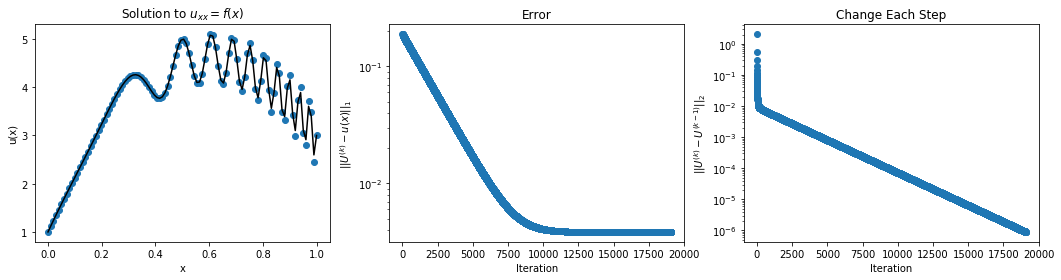

In [11]:
def jacobi_update(x, U, f, delta_x):
    """Update U with a single Jacobi iteration"""
    U_new = U.copy()
    for i in range(1, x.shape[0] - 1):
        U_new[i] = 0.5 * (U[i+1] + U[i-1]) - f(x[i]) * delta_x**2 / 2.0
    step_size = numpy.linalg.norm(U_new - U, ord=2)
    del(U)
    return U_new, step_size


# Problem setup
a = 0.0
b = 1.0
alpha = 1.0
beta = 3.0
phi = lambda x: 20.0 * numpy.pi * x**3
phi_prime = lambda x: 60.0 * numpy.pi * x**2
phi_dbl_prime = lambda x: 120.0 * numpy.pi * x
f = lambda x: -20.0 + 0.5 * (phi_dbl_prime(x) * numpy.cos(phi(x)) - (phi_prime(x))**2 * numpy.sin(phi(x)))
u_true = lambda x: 1.0 + 12.0 * x - 10.0 * x**2 + 0.5 * numpy.sin(phi(x))

# Descretization
m = 100
x_bc = numpy.linspace(a, b, m + 2)
x = x_bc[1:-1]
delta_x = (b - a) / (m + 1)

# Expected iterations needed
iterations_J = int(2.0 * numpy.log(delta_x) / numpy.log(1.0 - 0.5 * numpy.pi**2 * delta_x**2))
# iterations_J = 100

# Solve system
# Initial guess for iterations
U = 1.0 + 2.0 * x_bc
U[0] = alpha
U[-1] = beta
convergence_J = numpy.zeros(iterations_J)
step_size = numpy.zeros(iterations_J)
for k in range(iterations_J):
    U, step_size[k] = jacobi_update(x_bc, U, f, delta_x)
    convergence_J[k] = numpy.linalg.norm(delta_x * (u_true(x_bc) - U), ord=2)

# Plot result
fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 3)

axes = fig.add_subplot(1, 3, 1)
axes.plot(x_bc, U, 'o', label="Computed")
axes.plot(x_bc, u_true(x_bc), 'k', label="True")
axes.set_title("Solution to $u_{xx} = f(x)$")
axes.set_xlabel("x")
axes.set_ylabel("u(x)")

axes = fig.add_subplot(1, 3, 2)
axes.semilogy(list(range(iterations_J)), convergence_J, 'o')
axes.set_title("Error")
axes.set_xlabel("Iteration")
axes.set_ylabel("$||U^{(k)} - u(x)||_1$")

axes = fig.add_subplot(1, 3, 3)
axes.semilogy(list(range(iterations_J)), step_size, 'o')
axes.set_title("Change Each Step")
axes.set_xlabel("Iteration")
axes.set_ylabel("$||U^{(k)} - U^{(k-1)}||_2$")

plt.show()

We eventually converge although we see that there is a lower limit to the effectiveness of the Jacobi iterations.  We also again observe the extremely slow convergence we expect.  What if we could still take advantage of Jacobi though?  

0.004787033973514997
0.002976859571820206
0.002548970538646394
0.0023700892780919966
0.0022659230300685735


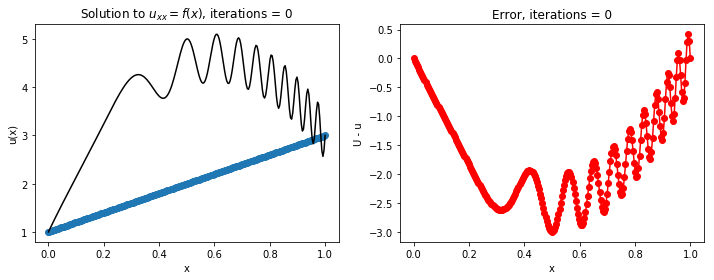

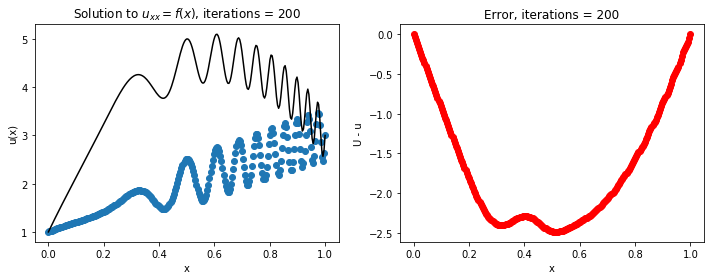

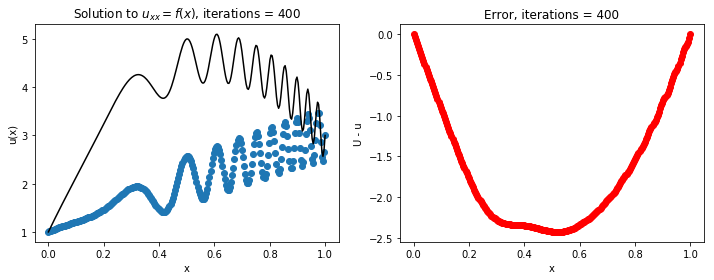

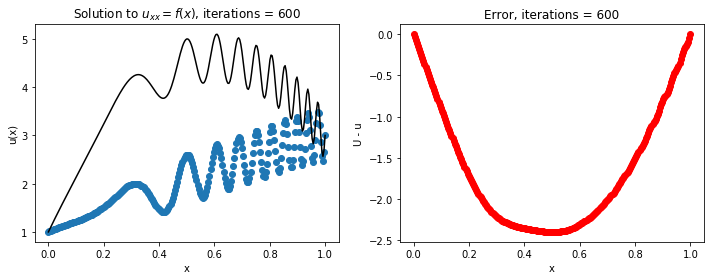

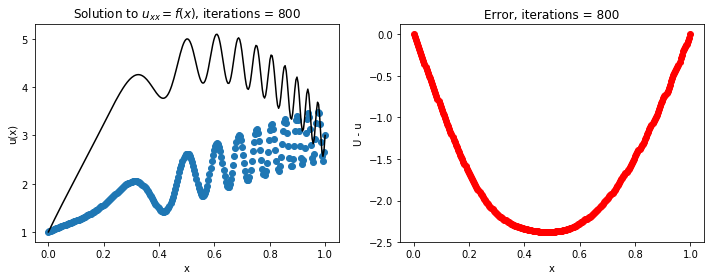

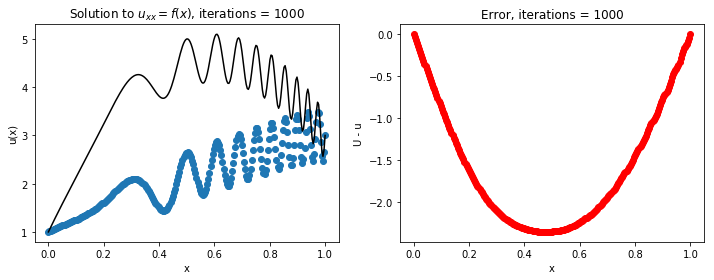

In [12]:
# Problem setup
a = 0.0
b = 1.0
alpha = 1.0
beta = 3.0
phi = lambda x: 20.0 * numpy.pi * x**3
phi_prime = lambda x: 60.0 * numpy.pi * x**2
phi_dbl_prime = lambda x: 120.0 * numpy.pi * x
f = lambda x: -20.0 + 0.5 * (phi_dbl_prime(x) * numpy.cos(phi(x)) - (phi_prime(x))**2 * numpy.sin(phi(x)))
u_true = lambda x: 1.0 + 12.0 * x - 10.0 * x**2 + 0.5 * numpy.sin(phi(x))

# Descretization
m = 255
x_bc = numpy.linspace(a, b, m + 2)
x = x_bc[1:-1]
delta_x = (b - a) / (m + 1)

U = 1.0 + 2.0 * x_bc
U[0] = alpha
U[-1] = beta

num_steps = 1000
plot_frequency = 200

# Plot initial error
fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 2)

axes = fig.add_subplot(1, 2, 1)
axes.plot(x_bc, U, 'o', label="Computed")
axes.plot(x_bc, u_true(x_bc), 'k', label="True")
axes.set_title("Solution to $u_{xx} = f(x)$, iterations = %s" % 0)
axes.set_xlabel("x")
axes.set_ylabel("u(x)")

axes = fig.add_subplot(1, 2, 2)
axes.plot(x_bc, U - u_true(x_bc), 'r-o')
axes.set_title("Error, iterations = %s" % 0)
axes.set_xlabel("x")
axes.set_ylabel("U - u")

# Start Jacobi iterations
for k in range(num_steps):
    U, step_size = jacobi_update(x_bc, U, f, delta_x)

    if (k+1)%plot_frequency == 0:
        print(step_size)
        fig = plt.figure()
        fig.set_figwidth(fig.get_figwidth() * 2)

        axes = fig.add_subplot(1, 2, 1)
        axes.plot(x_bc, U, 'o', label="Computed")
        axes.plot(x_bc, u_true(x_bc), 'k', label="True")
        axes.set_title("Solution to $u_{xx} = f(x)$, iterations = %s" % (k + 1))
        axes.set_xlabel("x")
        axes.set_ylabel("u(x)")

        axes = fig.add_subplot(1, 2, 2)
        axes.plot(x_bc, U - u_true(x_bc), 'r-o')
        axes.set_title("Error, iterations = %s" % (k + 1))
        axes.set_xlabel("x")
        axes.set_ylabel("U - u")

plt.show()

Note that higher frequency components of the error are removed first!  Why might this be?

Recall that we found in general that the error $e^{(k)}$ from a matrix splitting iterative approach involves the matrix $G$ where
$$
    U^{(k+1)} = M^{-1} N U^{(k)} + M^{-1} b = G U^{(k)} + c.
$$
We then know that
$$
    e^{(k)} = G e^{(k-1)}.
$$

In the case for Jacobi the matrix $G$ can be written as
$$
    G = I + \frac{\Delta x^2}{2} A = \begin{bmatrix}
        0 & 1/2 & \\
        1/2 & 0 & 1/2 \\
         & 1/2 & 0 & 1/2 \\
         & & \ddots & \ddots & \ddots \\
         & & & 1/2 & 0 & 1/2 \\
         & & & & 1/2 & 0
    \end{bmatrix}
$$
Note that this amounts to averaging the off diagonal terms $U_{i+1}$ and $U_{i-1}$.  Averaging has the effect of smoothing, i.e. it damps out higher frequencies more quickly.

Recall that the eigenvectors of $A$ and $G$ are the same, if those eigenvectors are
$$
    u^p_j = \sin(\pi p x_j) \quad \text{with} \quad x_j = j \Delta x, \quad j = 1, 2, 3, \ldots, m.
$$
with eigenvalues
$$
    \lambda_p = \cos(p \pi \Delta x).
$$

We can project the initial error $e^{(0)}$ onto the eigenspace such that
$$
    e^{(0)} = c_1 u^1 + c_2 u^2 + \cdots + c_m u^m
$$
and therefore
$$
    e^{(k)} = c_1 (\lambda_1)^k u^1 + c_2 (\lambda_2)^k u^2 + \cdots + c_m (\lambda_m)^k u^m.
$$
This implies that the $p$th component of the vector $e^{(k)}$ decays as the corresponding eigenvalue.

Examining the eigenvalues we know that the 1st and $m$th eigenvalues will be closest to 1 so the terms $c_1 (\lambda_1)^k u^1$ and $c_m (\lambda_m)^k u^m$ will dominate the error as
$$
    \lambda_1 = -\lambda_m \approx 1- \frac{1}{2} \pi^2 \Delta x^2.
$$
We saw this before as this determined the overall convergence rate for Jacobi.


<font color = "red"> 
   All $\lambda$ will be less than 1. We can play with $\Delta x$ (multigrid). 

For other components of the error we can approximately see how fast they will decay.  If $m / 4 \leq p \leq 3m / 4$ then
$$
    |\lambda_p| \leq \frac{1}{\sqrt{2}} \approx 0.7
$$
implying that after 20 iterations we would have $|\lambda_p|^20 < 10^{-3}$.

<font color = "red"> 
  The first eigenvalue will decay very slowly and that is an issue. 

Connecting this back to our original supposition that higher order frequencies in the error are damped more quickly look at the form of the eigenvector components.  The original error was projected onto the eigenvectors so that
$$
    e^{(0)} = c_1 u^1 + c_2 u^2 + \cdots + c_m u^m,
$$
plugging in the eigenvectors themselves we find
$$
    e^{(0)} = c_1 \sin(\pi x_j) + c_2 \sin(\pi 2 x_j) + \cdots + c_m \sin(\pi m x_j)
$$
so that we have effectively broken down the original error in terms of a Fourier sine series.  

Now considering our analysis on the eigenvalues we see that it is in fact the middle range of frequencies that decay the most quickly.  The reason we did not see this in our example is that the solution did not contain high-order frequencies relative to our choice of $m$.  If we picked an $m$ that was too small we would have been in trouble (for multiple reasons).  Try this out and see what you observe.

<font color = "red"> 
  We are targeting error frequencies on a different resolution and we get rid of them. That is why we change resolutions by going up and down. 

It turns out that having only the middle ranges decay quickly is suboptimal in the context we are considering.  Instead we will user *underrelaxed Jacobi*, similar to SOR from before, where
$$
    U^{(k+1)} = (1 - \omega) U^{(k)} + \omega G U^{(k)}
$$
with $\omega = 2/3$ (where $G$ is Jacobi's iteration matrix).  The new iteration matrix is
$$
    G_\omega = (1 - \omega) I + \omega G
$$
and has eigenvalues
$$
    \lambda_p = (1-\omega)+\omega \cos (p \pi \Delta x).
$$

This choice of $\omega$ in fact then minimizes the eigenvalues in the range $m/2 < p < m$.  In fact
$$
    |\lambda_p| \leq 1/3
$$
for this range.  As a standalone method this is actually worse than Jacobi as the lower frequency components of the error decay even more slowly than before but this behavior is perfect for a multigrid approach.

### Multigrid Approach

The basic approach for multigrid is to do the following:

1. Use a few iterations of underrelaxed Jacobi to damp high-frequency components of the error.
1. Since the error is now smoother than before we can represent the solution (and error) as a coarser resolution grid.  We then switch to a coarser resolution.
1. On this coarser grid we then again apply a few iterations of underrelaxed Jacobi which now quickly removes a set of lower-frequency components of the error since we are on a coarser grid.

Consider the $p = m/4$ component that on the original grid will not be damped much since it is in the lower-frequency range.  If we transfer the problem now to a grid with half as many points we then find that the previous frequency is now at the midpoint of the frequency range and therefore will be damped much more quickly!

One important point here is that instead of transferring the solution to the coarser grid we only transfer the error.

If we have taken $n$ iterations on the original grid we would now have
$$
    e^{(n)} = U^{(n)} - u
$$
which has a residual vector of
$$
    r^{(n)} = f - A U^{(n)}
$$
since
$$
    A e^{(n)} = -r^{(n)}.
$$
If we can solve this system for $e^{(n)}$ then we could go back and simply subtract this from the equation relating our numerical solution $U^{(n)}$ to $u$.  The system of equations relating the error and residual is the one we are interested in coarsening.

Basic Algorithm:
1. Take $n$ iterations (where $n$ is fixed) of a simple iterative method on the original problem $A u = f$.  This gives the approximate solution $U^{(n)} \in \mathbb R^m$.
1. Compute the residual $r^{(n)} = f - A U^{(n)} \in \mathbb R^m$.
1. Coarsen the residual problem, take $r^{(n)} \in \mathbb R^m$ to $\hat{r~} \in \mathbb R^{m_c}$ where $m_c = (m - 1) / 2$.
1. Approximately solve the new problem $\hat{A~} \hat{e~} = -\hat{r~}$ where $\hat{A~}$ is the appropriately scaled matrix $A$.
1. We now have an approximation to the error $e^{(k)}$ in $\hat{e~}$.  To get back to $e^{(k)}$ we use an appropriate interpolation method to go back to $\mathbb R^m$.  Now subtract this interpolated approximate error to get a new approximation $U$ to $u$.
1. Using this new value of $U$ as an initial guess repeat the process.

There are many variations on this scheme, most notably that we do not need to stop at a single coarsening, we can continue to coarsen to dampen additional lower frequencies depending mostly on the number of grid points $m$ we started out with.  The specification of levels of coarsening combined with the interpolation back up to the original problem is called a *V-cycle*.

Also note that although we are solving multiple linear systems, each coarsened system decreases the number of points used by half (this is also adjustable).

![V-Cycle Example](./images/v-cycle.png)
![W-Cycle Example](./images/w-cycle.png)

In [13]:
def smoother(v, N, A, f):
    for i in range(N):
        for k in range(A.shape[0]):
            v[k] = (f[k] - numpy.dot(A[k,0:k], v[0:k]) - numpy.dot(A[k,k+1:], v[k+1:]) ) / A[k,k];        
    return v

def get_mat(A):
    f = A.shape[0]
    c =  int((f - 1) / 2 + 1)
    P = numpy.zeros((f, c))
    for k in range(c):
        P[2 * k, k] = 1.0
    for k in range(c - 1):
        P[2 * k + 1, k] = 0.5
        P[2 * k + 1, k + 1] = 0.5
    return P  

def vcycle(A, f):
    if A.shape[0] < 15:
        v = numpy.linalg.solve(A,f)
        return v  
    N = 5
    v = numpy.zeros(A.shape[0]);
    v = smoother(v, N, A, f)
    P = get_mat(A)
    remains = f - numpy.dot(A, v)
    remains_P = numpy.dot(P.T, remains)
    AP_P = numpy.dot(P.T, numpy.dot(A,P))
    recurse_V = vcycle(AP_P, remains_P)
    v = numpy.dot(P, recurse_V)
    v = smoother(v, N, A, f)
    return v       

Matrix condition number = 68.81258394163932


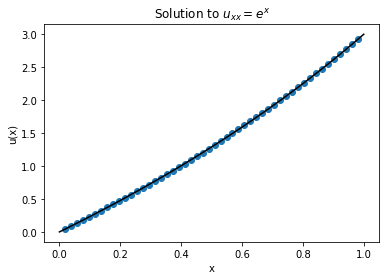

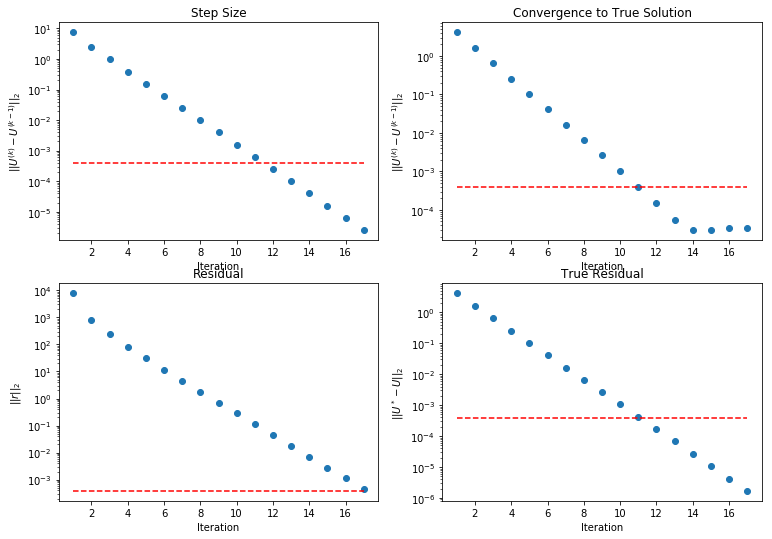

In [14]:
# Problem setup
a = 0.0
b = 1.0
alpha = 0.0
beta = 3.0
f = lambda x: numpy.exp(x)
u_true = lambda x: (4.0 - numpy.exp(1.0)) * x - 1.0 + numpy.exp(x)

# Descretization
m = 50
x_bc = numpy.linspace(a, b, m + 2)
x = x_bc[1:-1]
delta_x = (b - a) / (m + 1)

# Construct matrix A
A = numpy.zeros((m, m))
diagonal = numpy.ones(m) / delta_x**2
A += numpy.diag(diagonal * 2.0, 0)
A += numpy.diag(-diagonal[:-1], 1)
A += numpy.diag(-diagonal[:-1], -1)

# Construct right hand side
b = -f(x)
b[0] += alpha / delta_x**2
b[-1] += beta / delta_x**2

# True solution to system
U_true = numpy.linalg.solve(A, b)

# Algorithm parameters
MAX_CYCLES = 50
tolerance = delta_x**2

# Perform multi-grid
U = numpy.zeros(m)
convergence_MG = numpy.zeros(MAX_CYCLES)
step_size_MG = numpy.zeros(MAX_CYCLES)
residual_norm = numpy.zeros(MAX_CYCLES)
system_convergence = numpy.zeros(MAX_CYCLES)
success = False
for k in range(MAX_CYCLES):
    U_old = U.copy()
    
    # Compute residual
    r = b - numpy.dot(A, U)
    if numpy.linalg.norm(r, ord=2) < tolerance:
        success = True
        break       
    U += vcycle(A, r)
    
    # Convergence measures
    convergence_MG[k] = numpy.linalg.norm(u_true(x) - U, ord=2)
    residual_norm[k] = numpy.linalg.norm(r, ord=2)
    step_size_MG[k] = numpy.linalg.norm(U - U_old, ord=2)
    system_convergence[k] = numpy.linalg.norm(U_true - U, ord=2)

if not success:
    print("Iteration failed to converge!")
    print(residual_norm[-10:])
    print(convergence_CG[-10:])
else:
    # Plot result
    fig = plt.figure()
    axes = fig.add_subplot(1, 1, 1)
    axes.plot(x, U, 'o', label="Computed")
    axes.plot(x_bc, u_true(x_bc), 'k', label="True")
    axes.set_title("Solution to $u_{xx} = e^x$")
    axes.set_xlabel("x")
    axes.set_ylabel("u(x)")

    fig = plt.figure()
    fig.set_figwidth(fig.get_figwidth() * 2.1)
    fig.set_figheight(fig.get_figheight() * 2.2)
    
    axes = fig.add_subplot(2, 2, 1)
    axes.semilogy(numpy.arange(1, k + 1), step_size_MG[:k], 'o')
    axes.semilogy(numpy.arange(1, k + 1), numpy.ones(k) * delta_x**2, 'r--')
    axes.set_title("Step Size")
    axes.set_xlabel("Iteration")
    axes.set_ylabel("$||U^{(k)} - U^{(k-1)}||_2$")
    
    axes = fig.add_subplot(2, 2, 2)
    axes.semilogy(numpy.arange(1, k + 1), convergence_MG[:k], 'o')
    axes.semilogy(numpy.arange(1, k + 1), numpy.ones(k) * delta_x**2, 'r--')
    axes.set_title("Convergence to True Solution")
    axes.set_xlabel("Iteration")
    axes.set_ylabel("$||U^{(k)} - U^{(k-1)}||_2$")

    axes = fig.add_subplot(2, 2, 3)
    axes.semilogy(numpy.arange(1, k + 1), residual_norm[:k], 'o')
    axes.semilogy(numpy.arange(1, k + 1), numpy.ones(k) * delta_x**2, 'r--')
    axes.set_title("Residual")
    axes.set_xlabel("Iteration")
    axes.set_ylabel("$||r||_2$")

    axes = fig.add_subplot(2, 2, 4)
    axes.semilogy(numpy.arange(1, k + 1), system_convergence[:k], 'o')
    axes.semilogy(numpy.arange(1, k + 1), numpy.ones(k) * delta_x**2, 'r--')
    axes.set_title("True Residual")
    axes.set_xlabel("Iteration")
    axes.set_ylabel("$||U^* - U||_2$")
    
    print("Matrix condition number = %s" % (numpy.sqrt(numpy.linalg.norm(A) * numpy.linalg.norm(numpy.linalg.inv(A)))))
    
    plt.show()

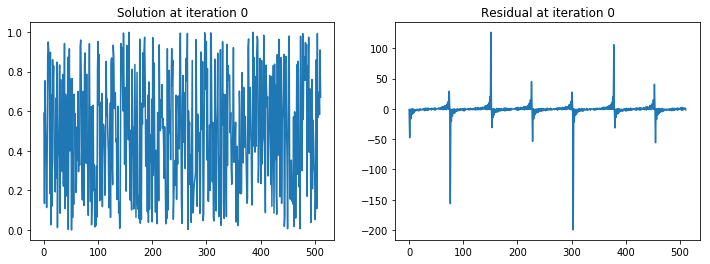

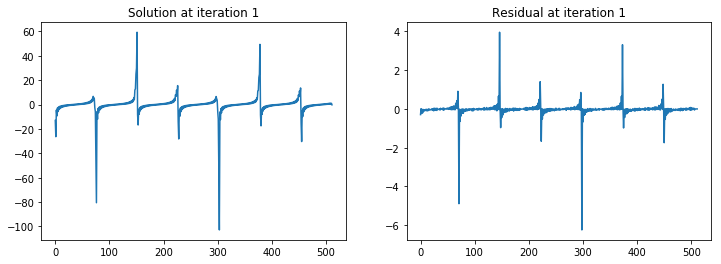

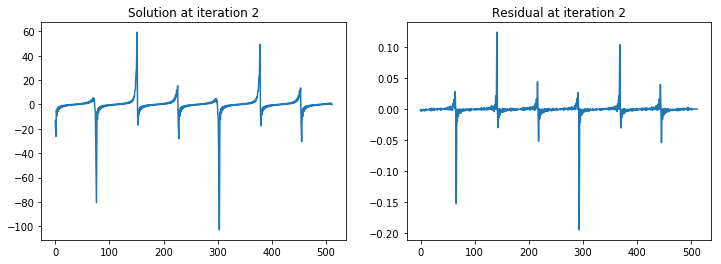

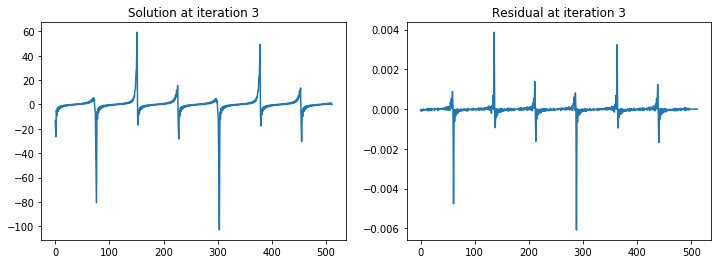

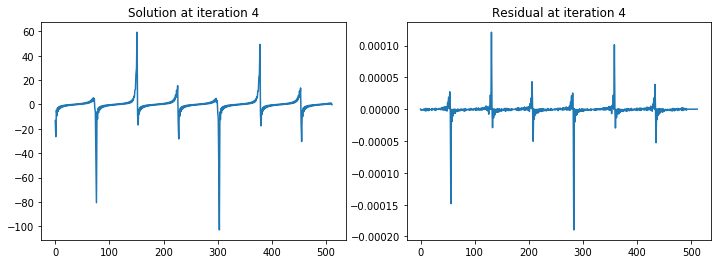

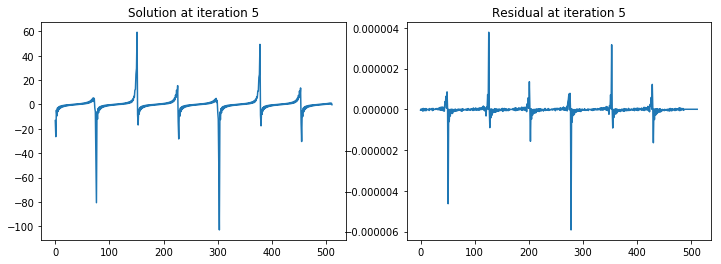

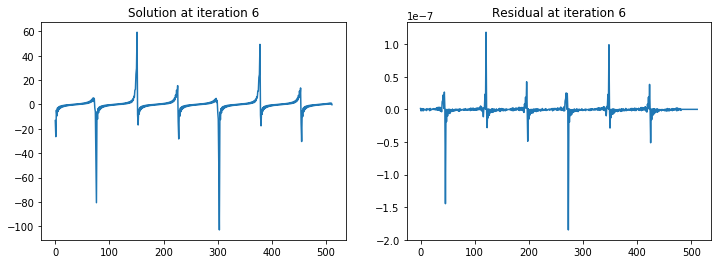

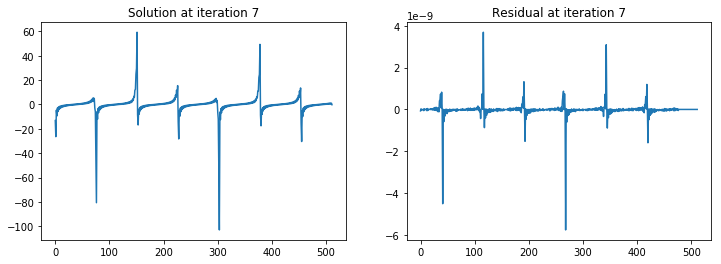

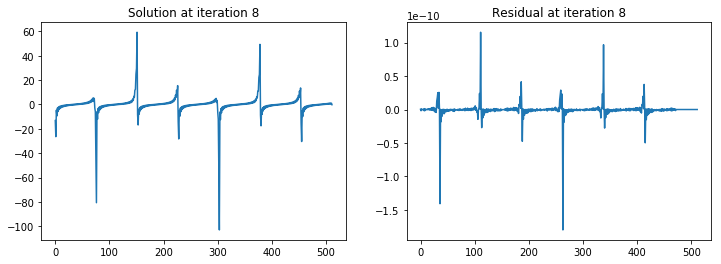

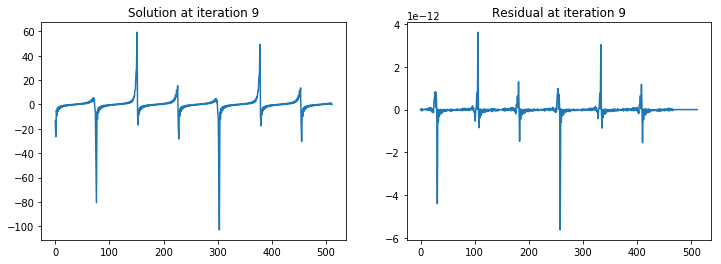

In [15]:
# Slightly harder problem
L = 1.0
m = 512
x_bc = numpy.linspace(0, L, m + 2)
x = x_bc[1:-1]
delta_x = (b - a) / (m + 1)

A = numpy.diag(2.0 * numpy.ones(m)) - numpy.diag(numpy.ones(m - 1),  1) / L**2

b = numpy.tan(numpy.arange(m) / (2 * numpy.pi) * 10)

U_true = numpy.linalg.solve(A, b)
U = numpy.random.random(m)

MAX_CYCLES = 50
tolerance = 1e-10

for k in range(MAX_CYCLES):
    r = b - numpy.dot(A, U)
    fig = plt.figure()
    fig.set_figwidth(fig.get_figwidth() * 2)
    axes = fig.add_subplot(1, 2, 1)
    axes.plot(U)
    axes.set_title("Solution at iteration %s" % k)
    axes = fig.add_subplot(1, 2, 2)
    axes.plot(r)
    axes.set_title("Residual at iteration %s" % k)
    
    if numpy.linalg.norm(r) < tolerance:
        break       

    U += vcycle(A, r)

### Work Estimates

So how much better is multigrid?

As a concrete example consider again the similar example from before where $m = 2^8 - 1 = 255$ and using $n = 3$.  If we allow recursive coarsening down to 3 grid points (7 levels of grids).  On each level we apply 3 iterations of Jacobi.  If we apply these Jacobi iterations on the way "down" the V-cycle and on the way up (not necessary in theory) we would do 6 iterations of Jacobi per level.  This leads to a total of 42 Jacobi iterations on variously coarsened grids.  The total number of updated values then would be
$$
    6 \sum^8_{j=2} 2^j \approx 3072.
$$
This is about the same amount of work as 12 iterations on the original fine grid would take.  The big difference here is that, due to the sweeping, we have in fact damped out error frequencies in a much larger range than would have been accomplished simply by Jacobi iterations.

Now consider the more general case with $m + 1 = 2^J$ points recursing all the way down to one point (about) and taking $n$ iterations of Jacobi at each level.  The total work would be
$$
    2 n \sum^J_{j=2}2^j \approx 4 n 2^J \approx 4 n m = \mathcal{O}(m)
$$
assuming $n \ll m$.  The work required work for one V-cycle, noting that the number of grids grows as $\log_2 m$, is still $\mathcal{O}(m)$.  It can actually also be shown for the Poisson problem that the number of V-cycles required in our simple approach that $\mathcal{O}(m \log m)$ would be required to reach a given level of error determined by the original $\Delta x$.

We can of course play with all sorts of types of V-cycles and iteration counts and these variations lead to a multitude of approaches. 

### Full Multigrid

Instead of starting and solving the original PDE at the finest level we can also start at the coarsest.  To do this we do a few iterations on the coarsest level or solve the problem directly since the cost should be low at the coarsest level.  We then interpolate to the next finer level and solve the problem there.  We can then cycle back down to the coarsest level or continue upwards until we get to the finest level where we wanted to be in the first place.  We then switch back to solving for the error rather than the original problem and proceed as before.  This approach is usually labeled as *full multigrid* (FMG).

![FMG-Cycle Example](./images/fmg-cycle.png)

It turns out that although there is a "startup" phase that this is mostly negligible and greatly reduces the error by the time we reach the finest level.  It turns out using FMG takes about $\mathcal{O}(m)$ work, optimal given that we have $m$ unknowns to solve for in the 1-dimensional problem.

### Take-Away

We have been discussing one-dimensional implementations of multigrid but these methods extend to higher-dimensional problems and continue to be optimal.  For instance a two-dimensional Poisson problem can be solved in $\mathcal{O}(m^2)$ work, again optimal due to the number of unknowns.  A Fourier transform approach would require $\mathcal{O}(m^2 \log m)$ and a direct method $\mathcal{O}(m^3)$.

This all being said, multigrid is hard.  There are as many ways to do it as their are problems to be solved (at least).  Luckily there are a number of areas where research has been done to determine optimal methods (in some sense) for a given problem and discretization.  There are also variations that include more complex ways to "coarsen" the error and residual.  In general these are called *algebraic multigrid* methods (AMG).  These are especially useful when it is not obvious how to coarsen the residual problem.

### Further Reading
1. W. L. Briggs, V. Emden Henson, and S. F. McCormick. *A Multigrid Tutorial, 2nd ed.* SIAM, Philadelphia, 2000.
1. D. C. Jesperson.  Multigrid methods for partial differential equations.  In *Studies in Numerical Analysis*, G.H. Golub, ed. MAA Studies in Mathematics, Vol. 24, 1984, pages 270-317.
1. W. Hackbusch. *Multigrid Methods and Applications.* Springer-Verlag, Berlin, 1985.
1. P. Wesseling. *An Introduction to Multigrid Methods*. John Wiley, New York, 1992.